# Project: Kaggle Competition
[2019 2nd ML month with KaKR - House Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

## Problem
20개의 변수로 집의 가격을 예측한다. <br>

## Metric
### RMSE
$\sqrt{\frac{1}{N}\Sigma (y_t - y_{pr})^2}$

## Data Fields
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
train = pd.read_csv(train_data_path, index_col=0)
test = pd.read_csv(test_data_path, index_col=0)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 20)
test data dim : (6468, 19)


# 2. EDA 및 전처리

## 1) 결측치 확인

<AxesSubplot:>

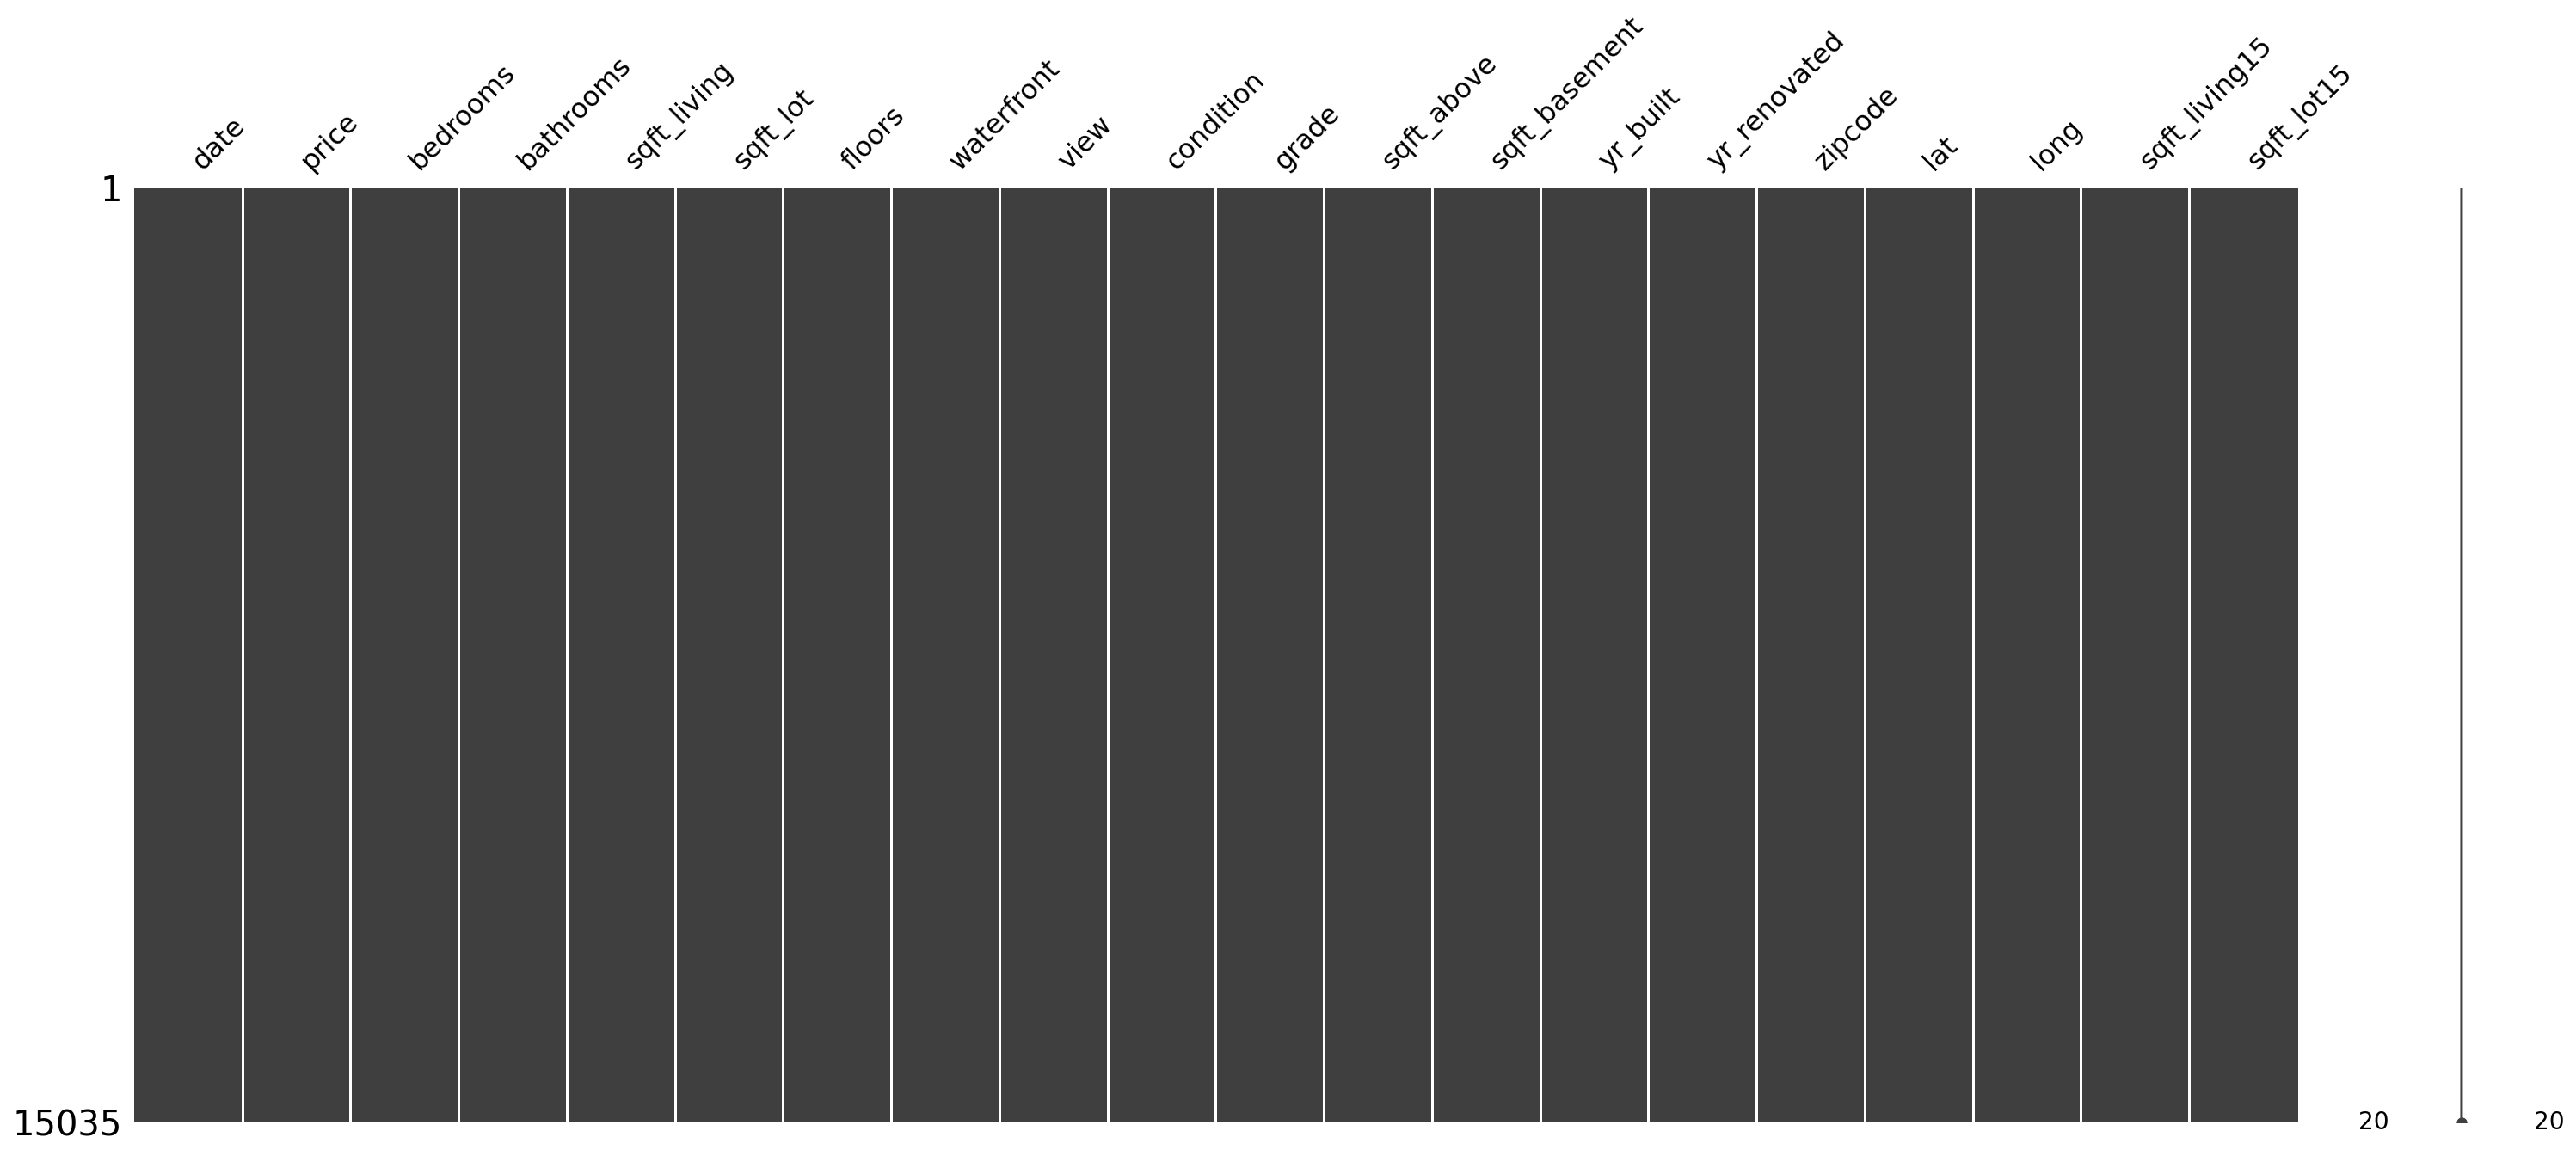

In [4]:
msno.matrix(train)

In [5]:
for c in train.columns:
    print(f'{c} : {len(train.loc[pd.isnull(train[c]), c].values)}')

date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## 2) 변수의 분포, 변수 간 상관관계 확인

In [53]:
# 연, 월만 가져오기 (정수형으로)
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test["date"] = test['date'].apply(lambda i: i[:6]).astype(int)

### 변수 탐색

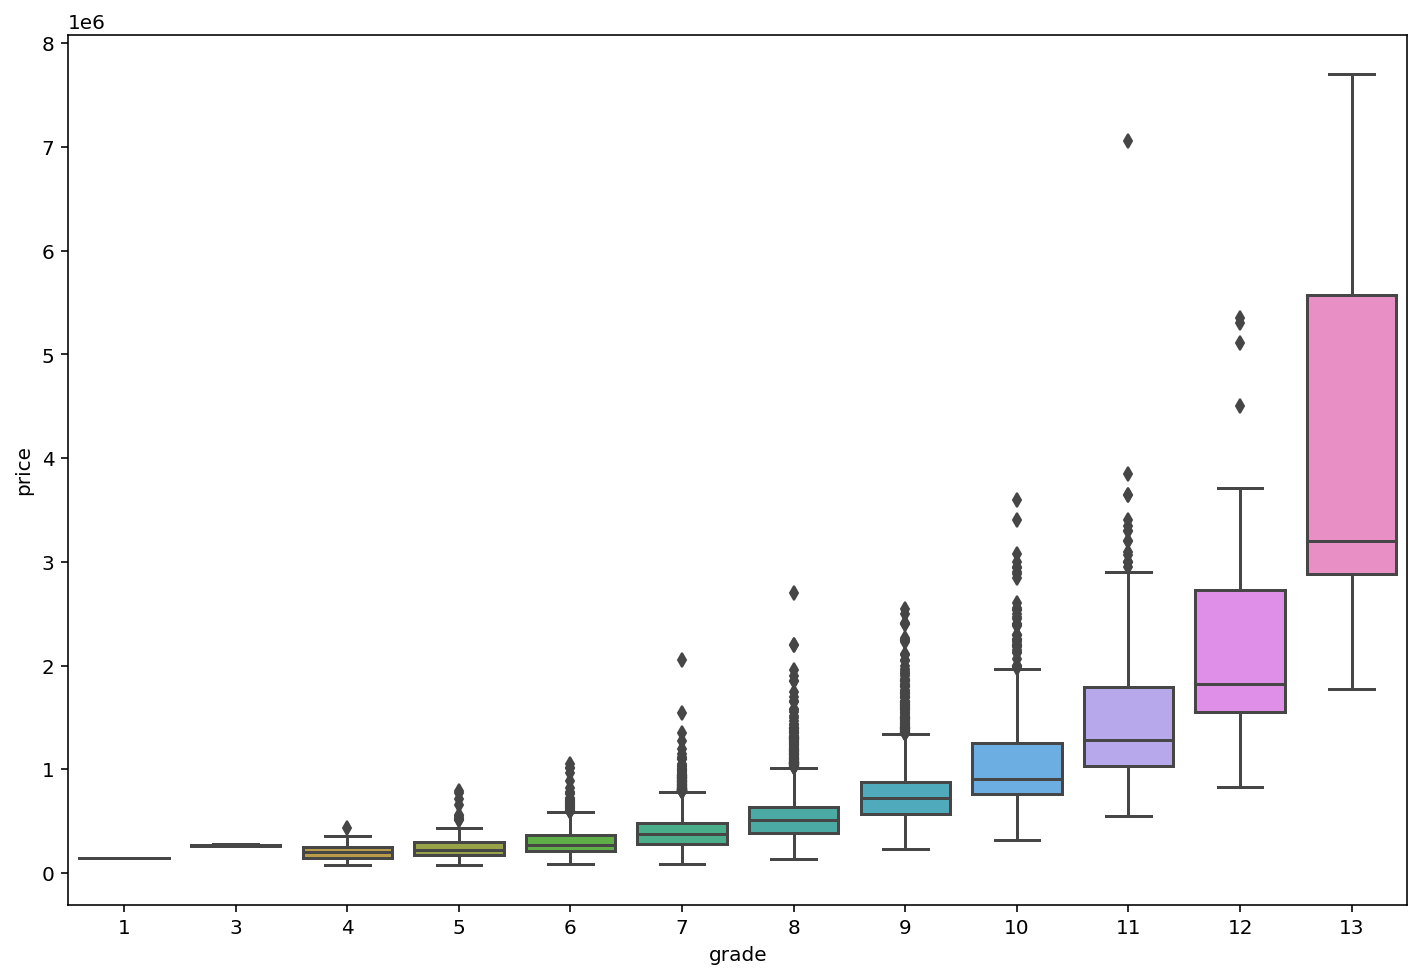

In [7]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=train.grade, y=train.price);

grade와 가격이 양의 상관관계를 갖고 있는 것으로 보인다. <br>
grade가 1, 3인 데이터가 적다 추후 확인해보고 필요 없으면 지워도 될 것 같다.

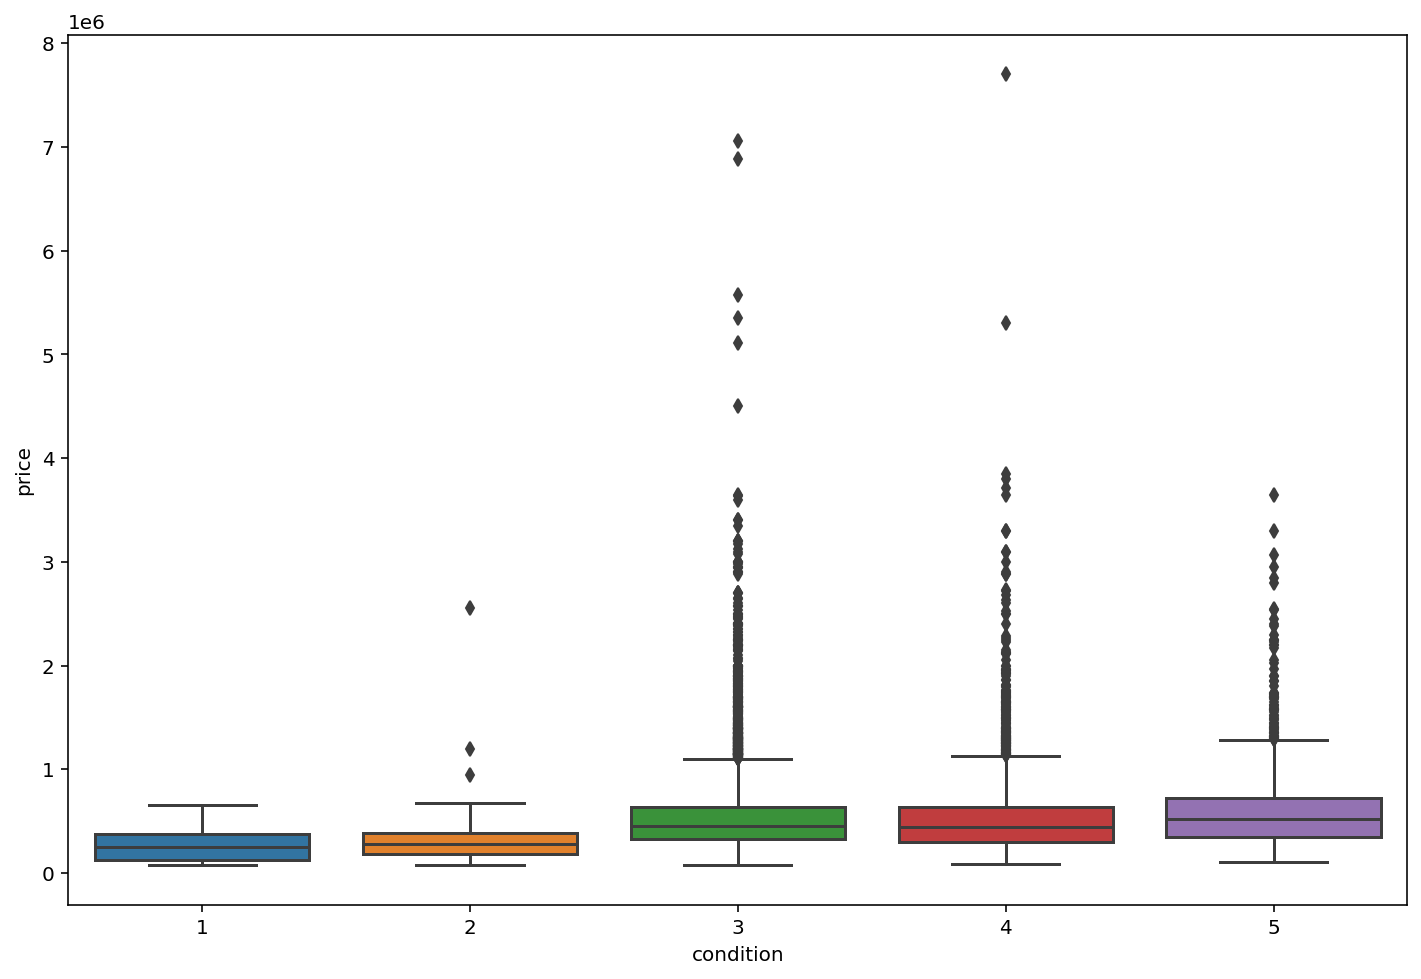

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=train.condition, y=train.price);

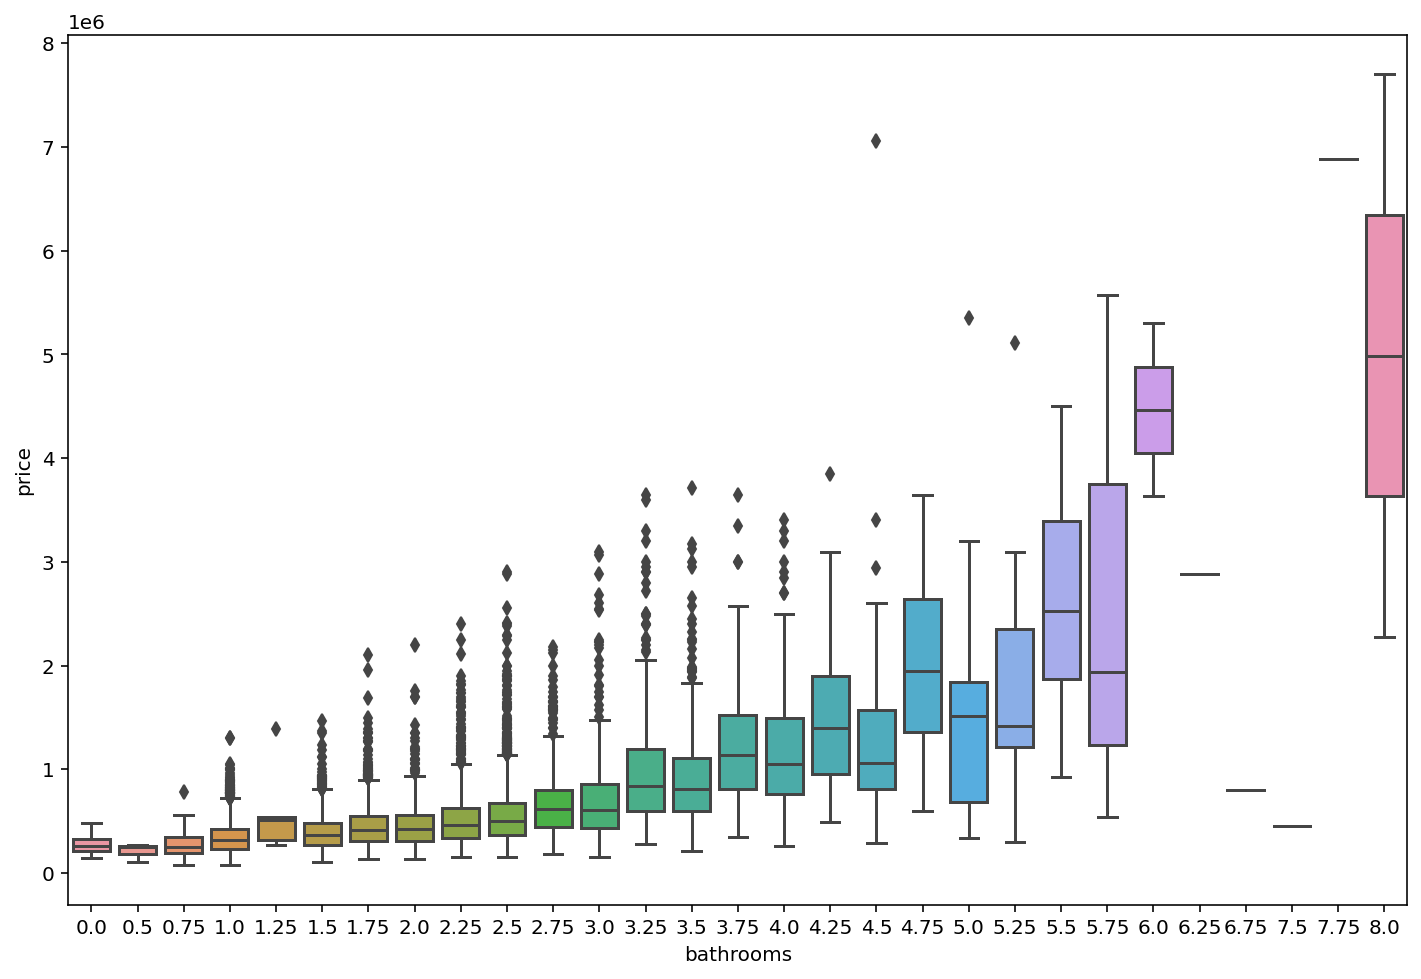

In [9]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=train.bathrooms, y=train.price);

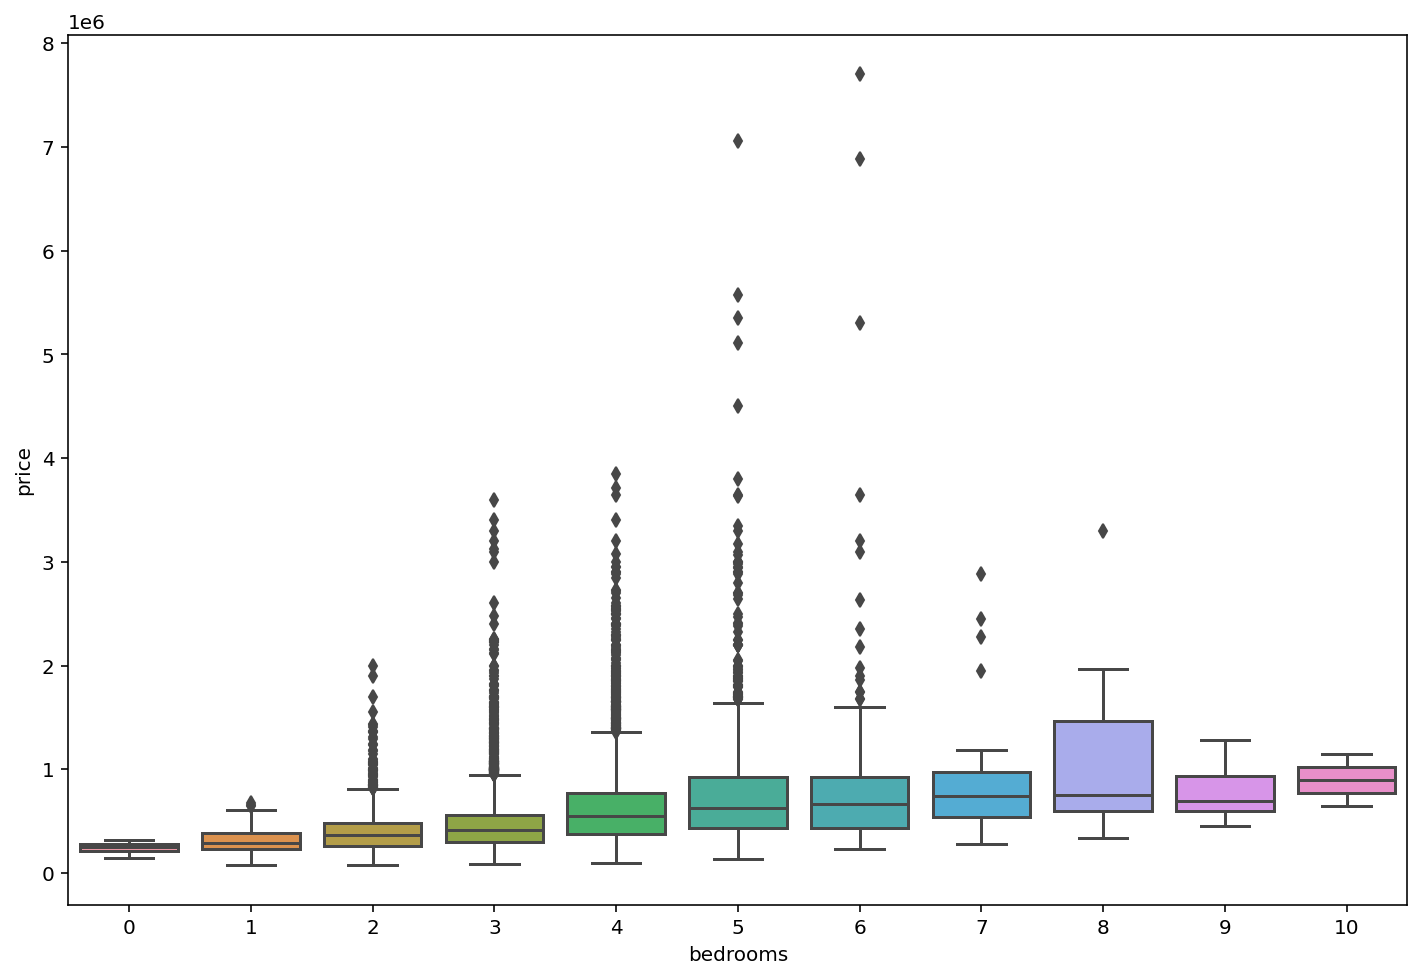

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=train.bedrooms, y=train.price);

중앙값은 어느 정도 선형관계를 보인다.방 개수가 적은데 비싼 곳들은 땅 값 자체가 비싼 동네에 있을 가능성이 있다.

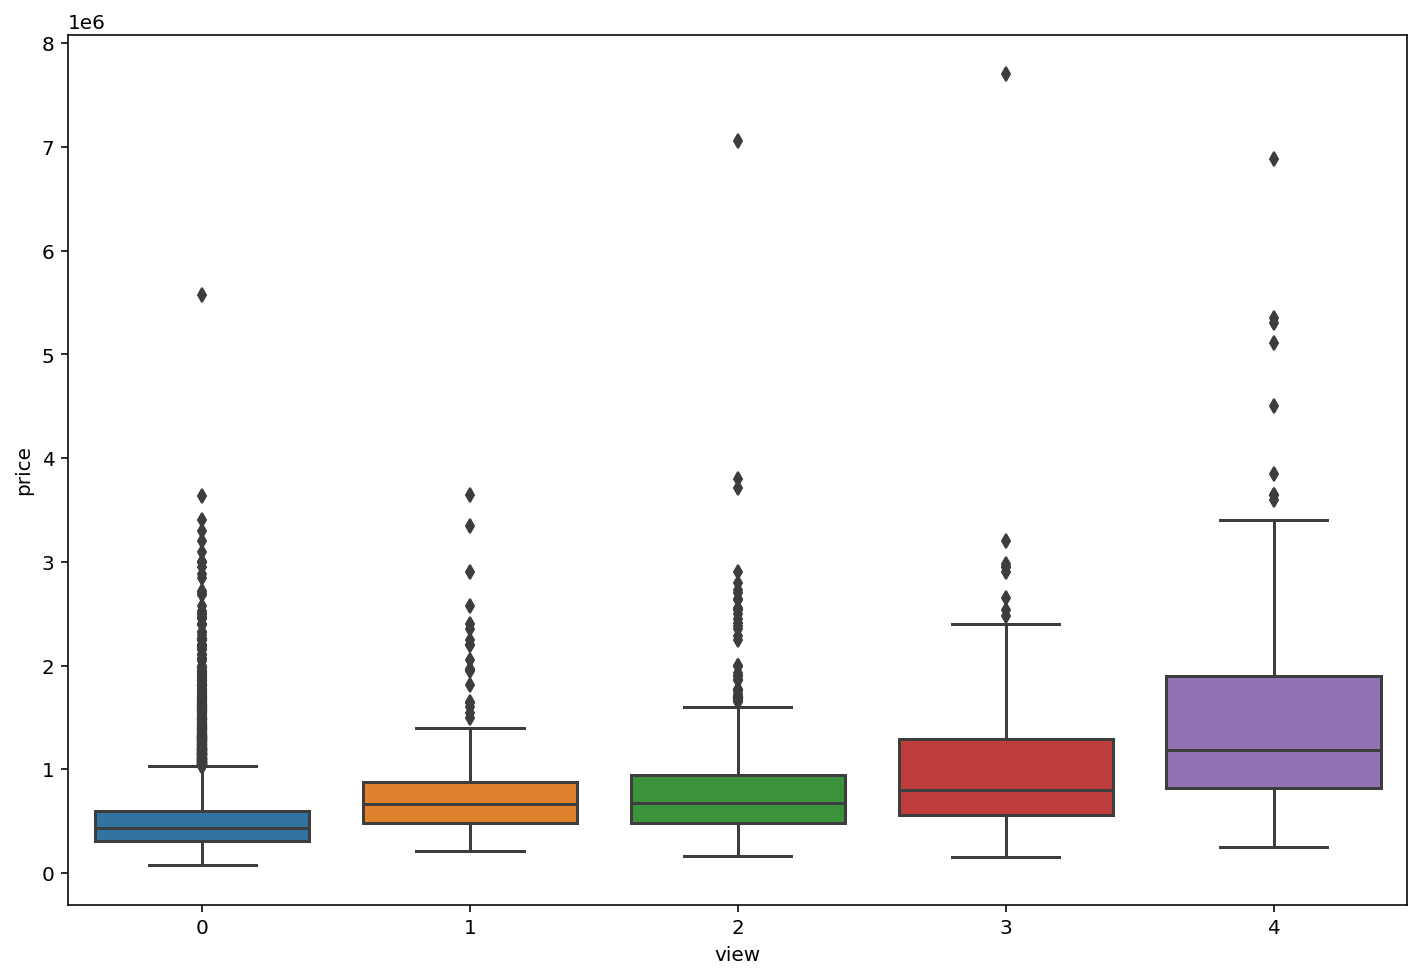

In [11]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=train.view, y=train.price);

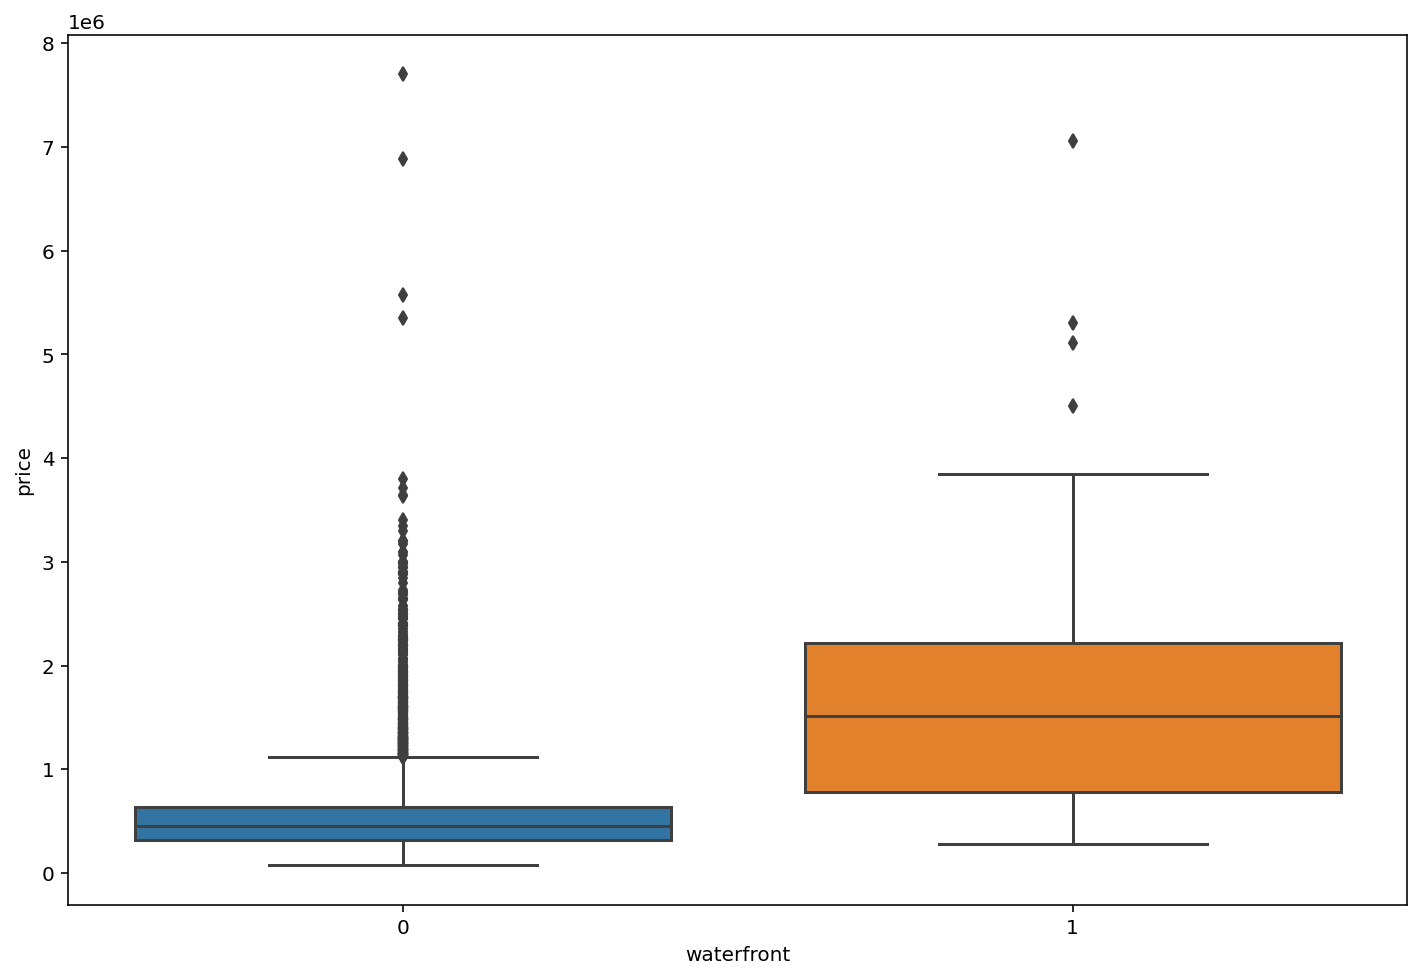

In [12]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=train.waterfront, y=train.price);

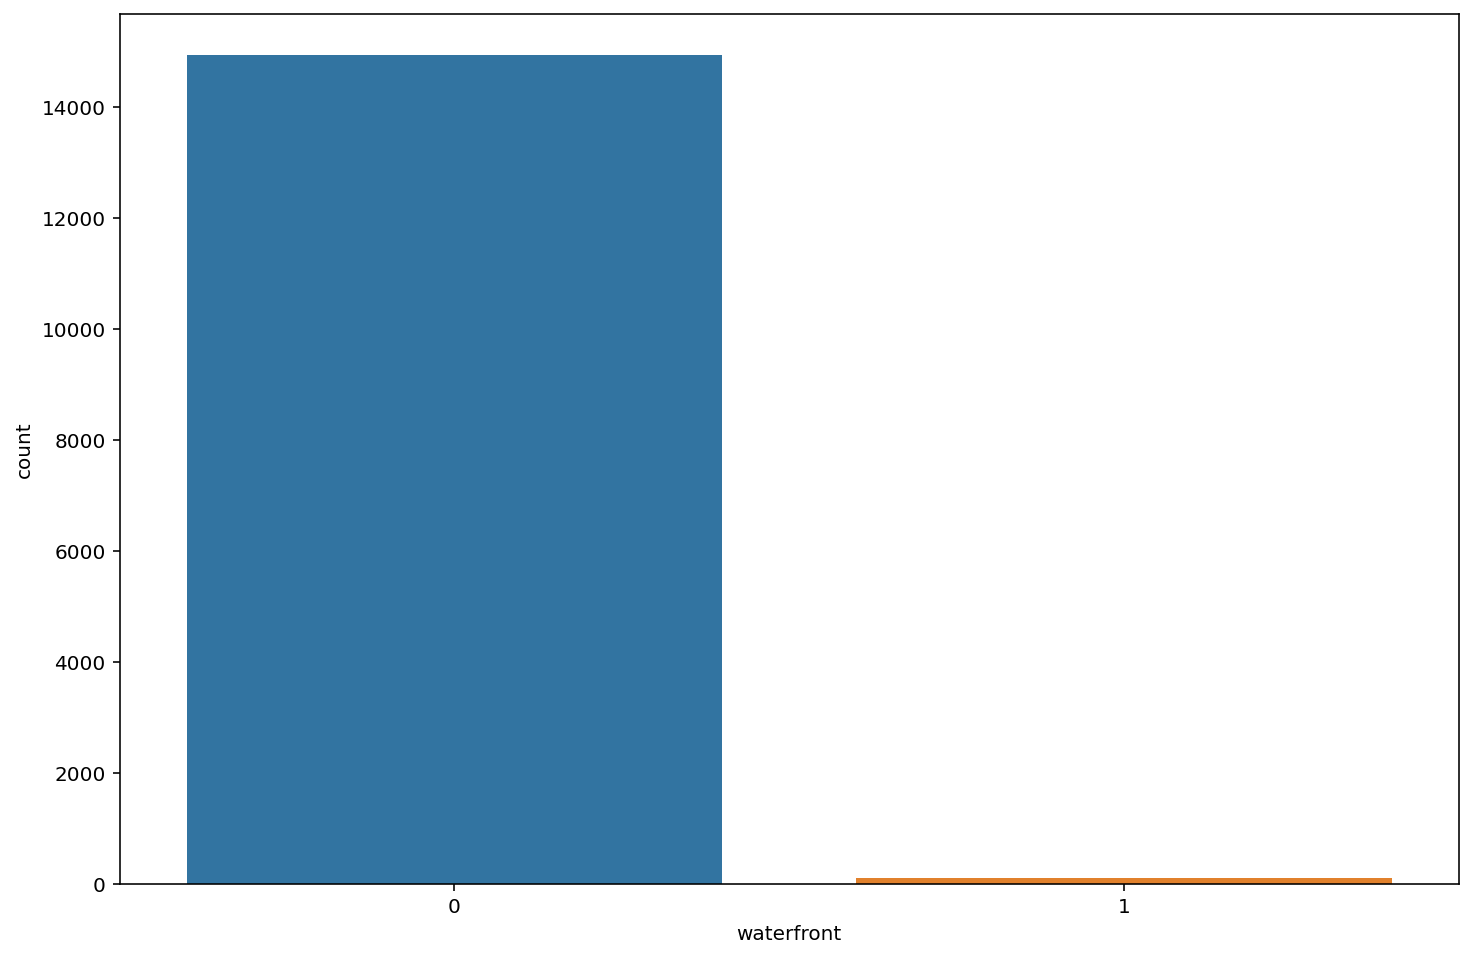

In [13]:
plt.figure(figsize=(12, 8))
sns.countplot(x=train.waterfront);

waterfront인 집의 수가 현저하게 적으며, 그들의 가격이 waterfront가 아닌 집보다 더 높게 형성되어 있다

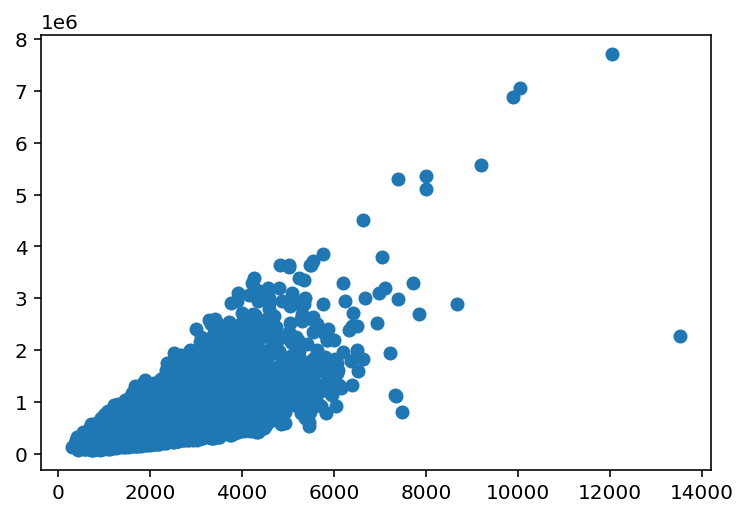

In [14]:
plt.scatter(x=train.sqft_living, y=train.price);

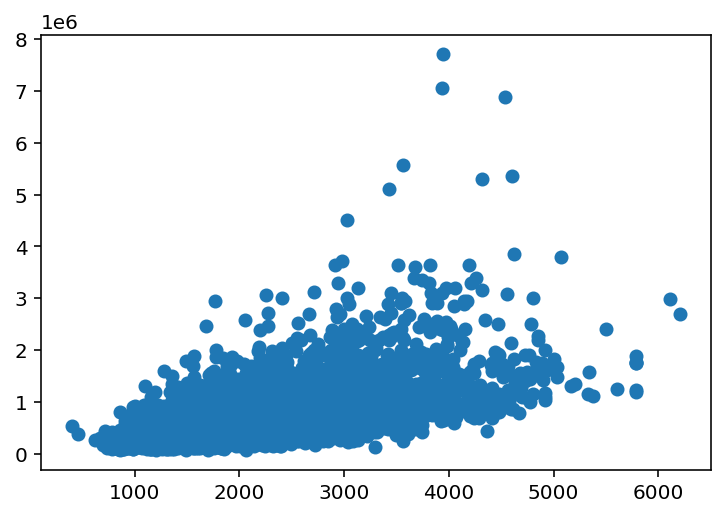

In [15]:
plt.scatter(x=train.sqft_living15, y=train.price);

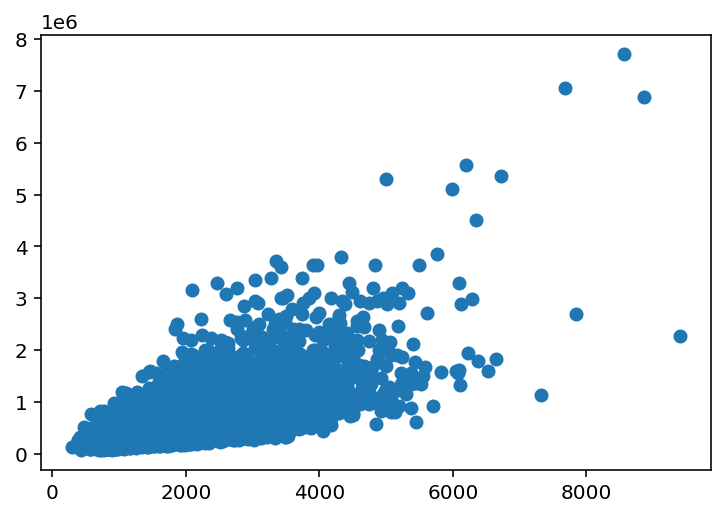

In [16]:
plt.scatter(x=train.sqft_above, y=train.price);

면적 관련 feature는 면적이 커질수록 금액이 높아지는 경향이 있어보인다. 중간 중간 있는 이상치는 추후 삭제한다.

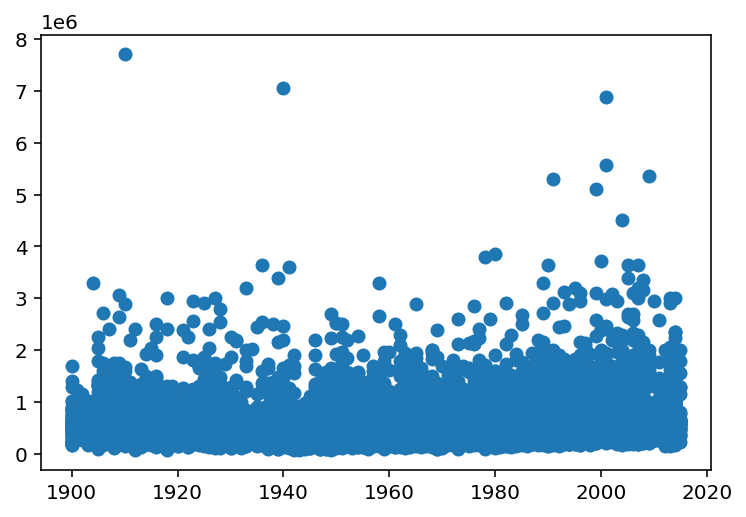

In [17]:
plt.scatter(x=train.yr_built, y=train.price);

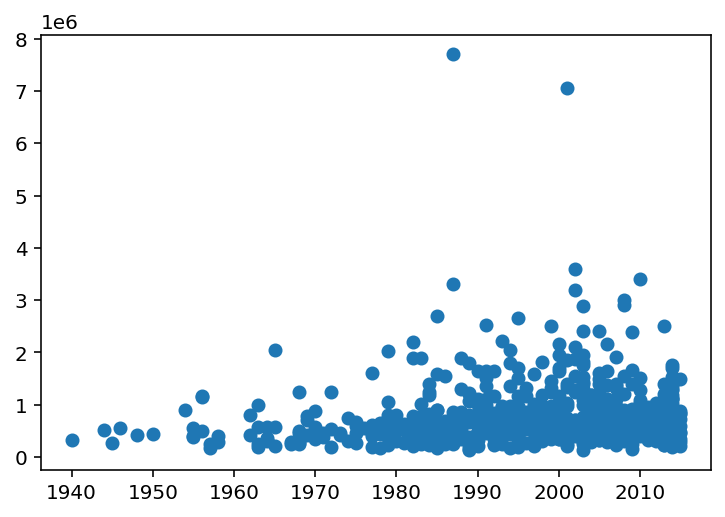

In [18]:
tmp = train.loc[train.yr_renovated > 0]
plt.scatter(x=tmp.yr_renovated, y=tmp.price);

건축년도와 재건축년도는 금액과 크게 관계 없는 것 같다

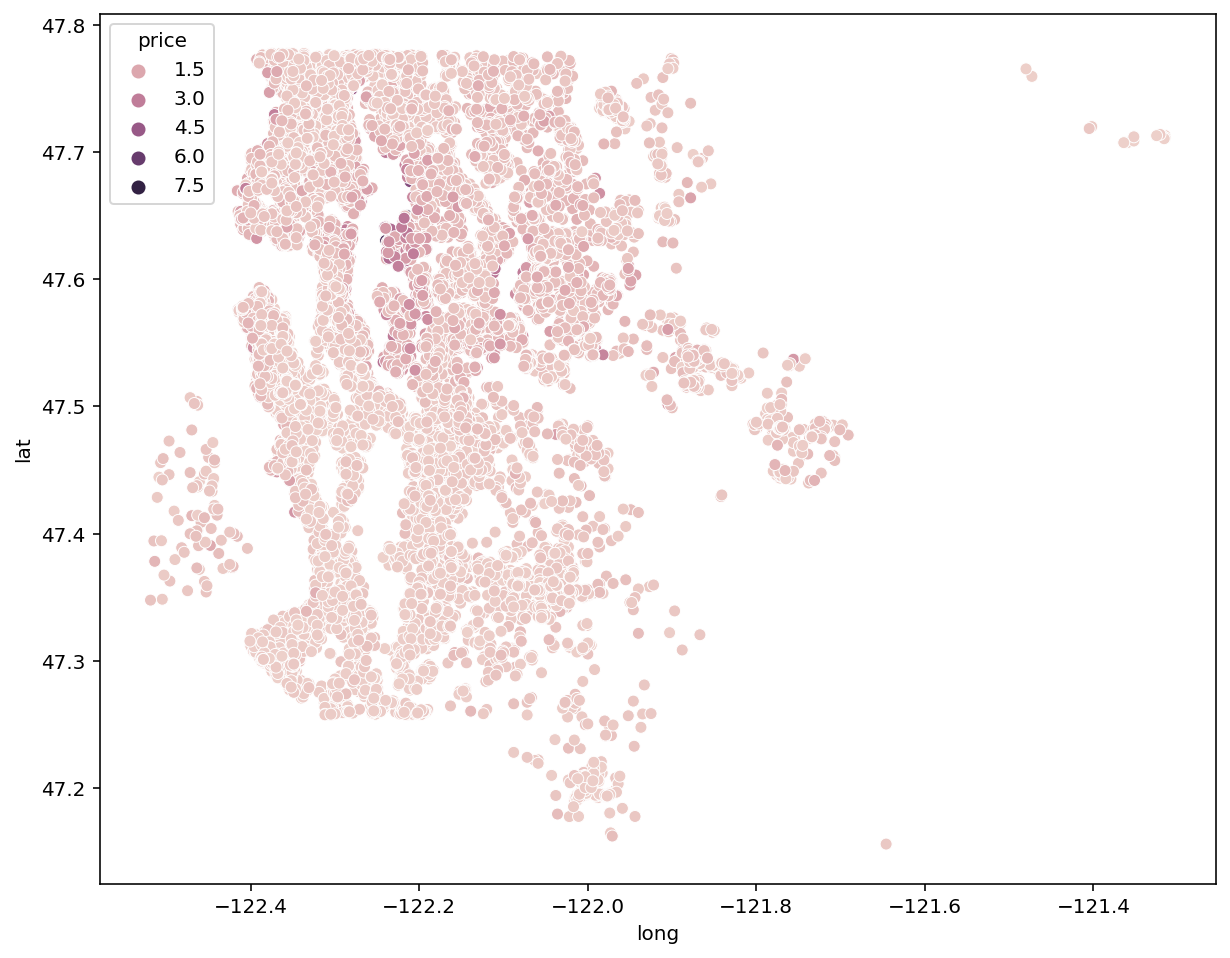

In [19]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="long", y="lat", hue="price", data=train);

가격대가 높은 중심부가 다운타운일 가능성이 높다

### 분포 확인

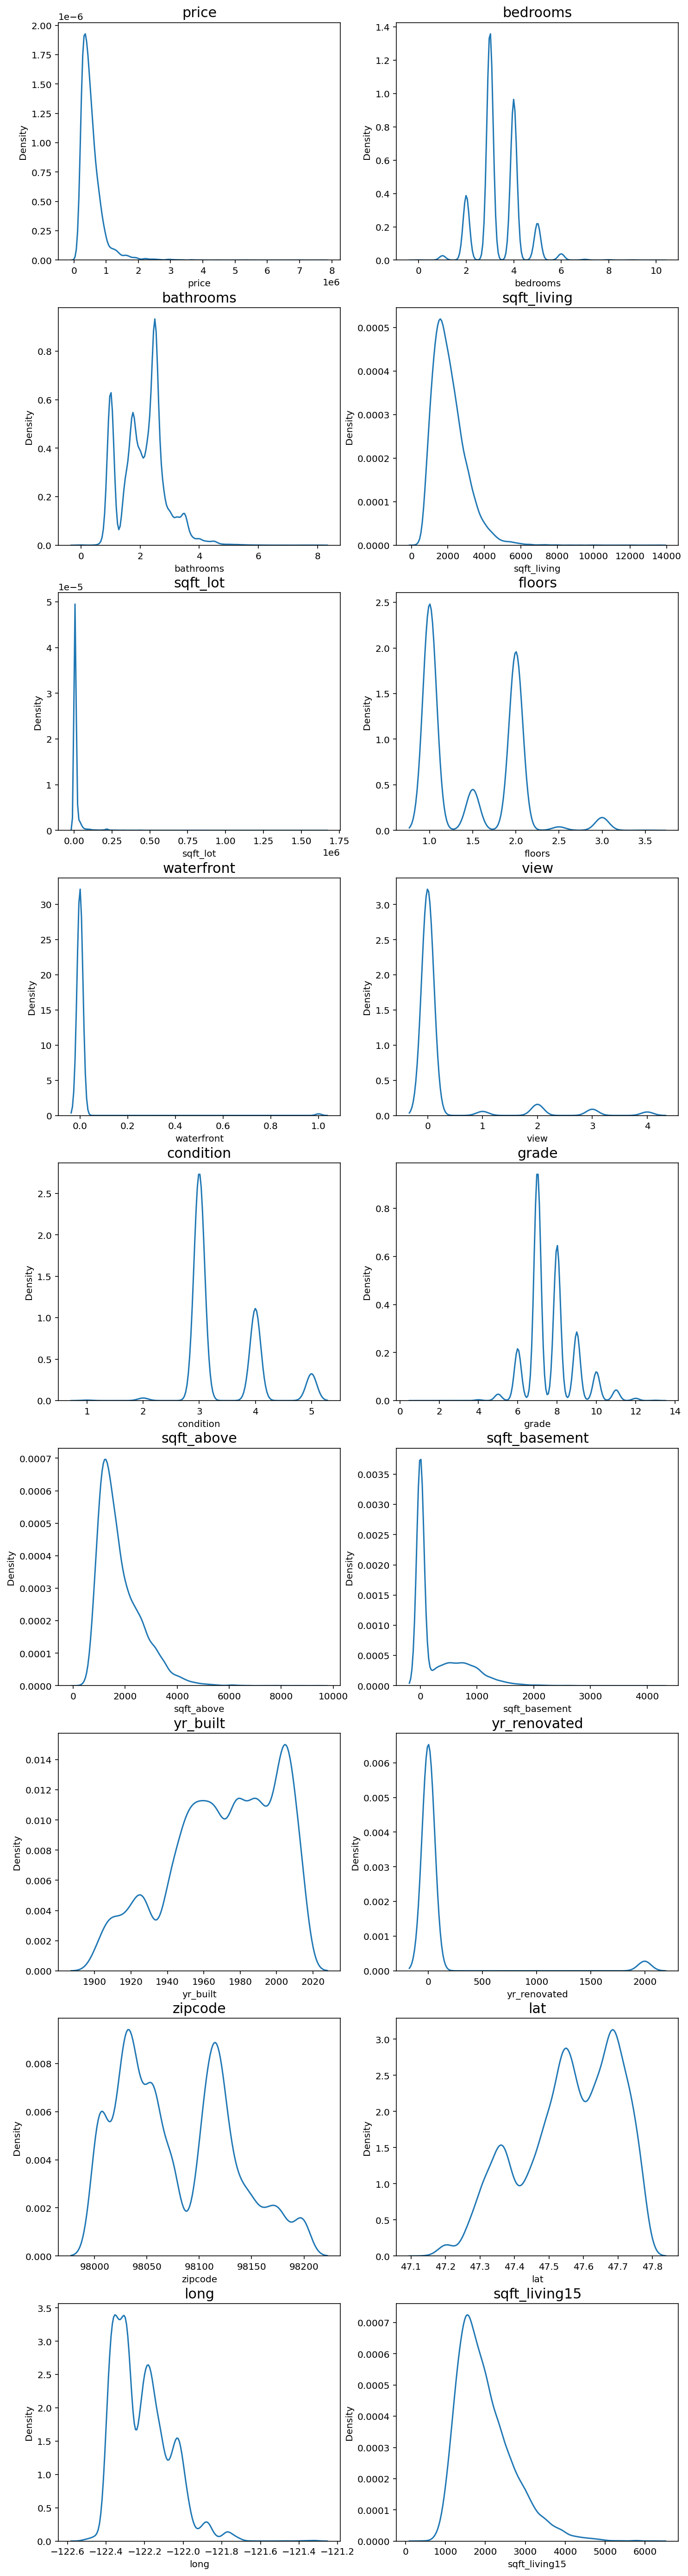

In [20]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

치우친 분포들이 있다. 추후 로그 스케일링을 진행하여 정규분포에 가깝게 만들어준다.

### 상관관계 확인

<AxesSubplot:>

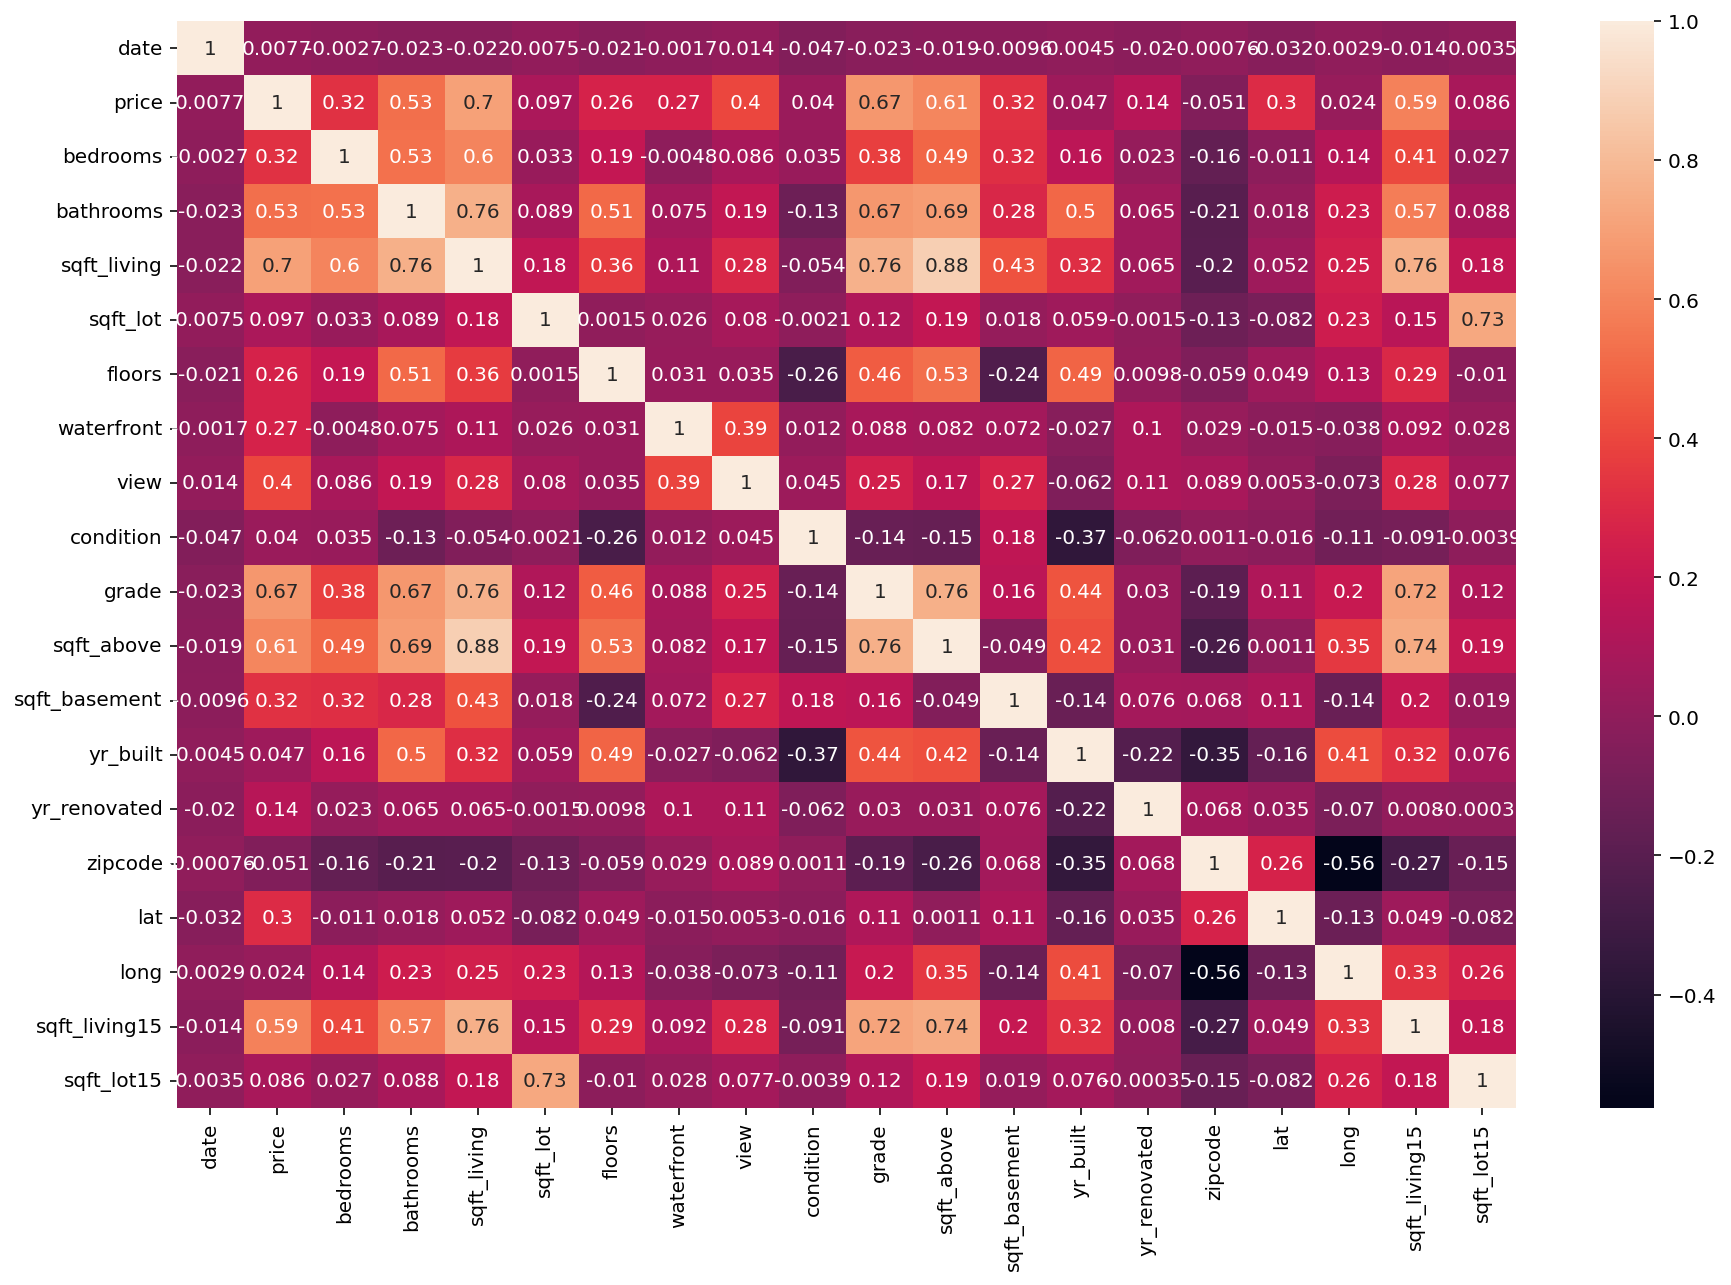

In [21]:
corr = train.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True)

집의 등급, 주거 면적, 지상층 면적, 15년도 주거 면적, 화장실 수 순서로 상관관계가 크다

## 3) 변수 생성 및 선택

### 이상치 제거

In [22]:
train.loc[train["sqft_living"] > 13000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [23]:
train = train.loc[train["sqft_living"] < 13000]

In [24]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
2302,201502,262000.0,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,201411,280000.0,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [25]:
train = train.loc[~((train['price']>12) & (train['grade'] == 3))]

위에서 그린 산점도를 바탕으로 찾은 값이다. <br>
표를 보면 가격이 그리 높은 것도 아닌데 주거 면적이 매우 넓다. <br>
이상치로 판정하고 삭제한다.

In [26]:
train.loc[train.grade == 1]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
13522,201409,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [27]:
train = train.loc[train.grade != 1]

grade가 1인 데이터는 하나 밖에 없고, 침실, 화장실이 없으므로 이상하다. 그러므로 지워준다. <br>

### 변수 생성

In [28]:
train["sqft_total"] = train["sqft_basement"] + train["sqft_above"] + train["sqft_lot"]
test["sqft_total"] = test["sqft_basement"] + test["sqft_above"] + test["sqft_lot"]
train["sqft_total15"] = train["sqft_living15"] + train["sqft_lot15"]
test["sqft_total15"] = test["sqft_living15"] + test["sqft_lot15"]
train["is_renovated"] = train["yr_renovated"].apply(lambda x: 0 if x == 0 else 1)
test["is_renovated"] = test["yr_renovated"].apply(lambda x: 0 if x == 0 else 1)

## 4) feature scaling

In [32]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_total', 'sqft_total15', 'sqft_lot15', 'sqft_living15', 'sqft_basement', "sqft_above"]

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

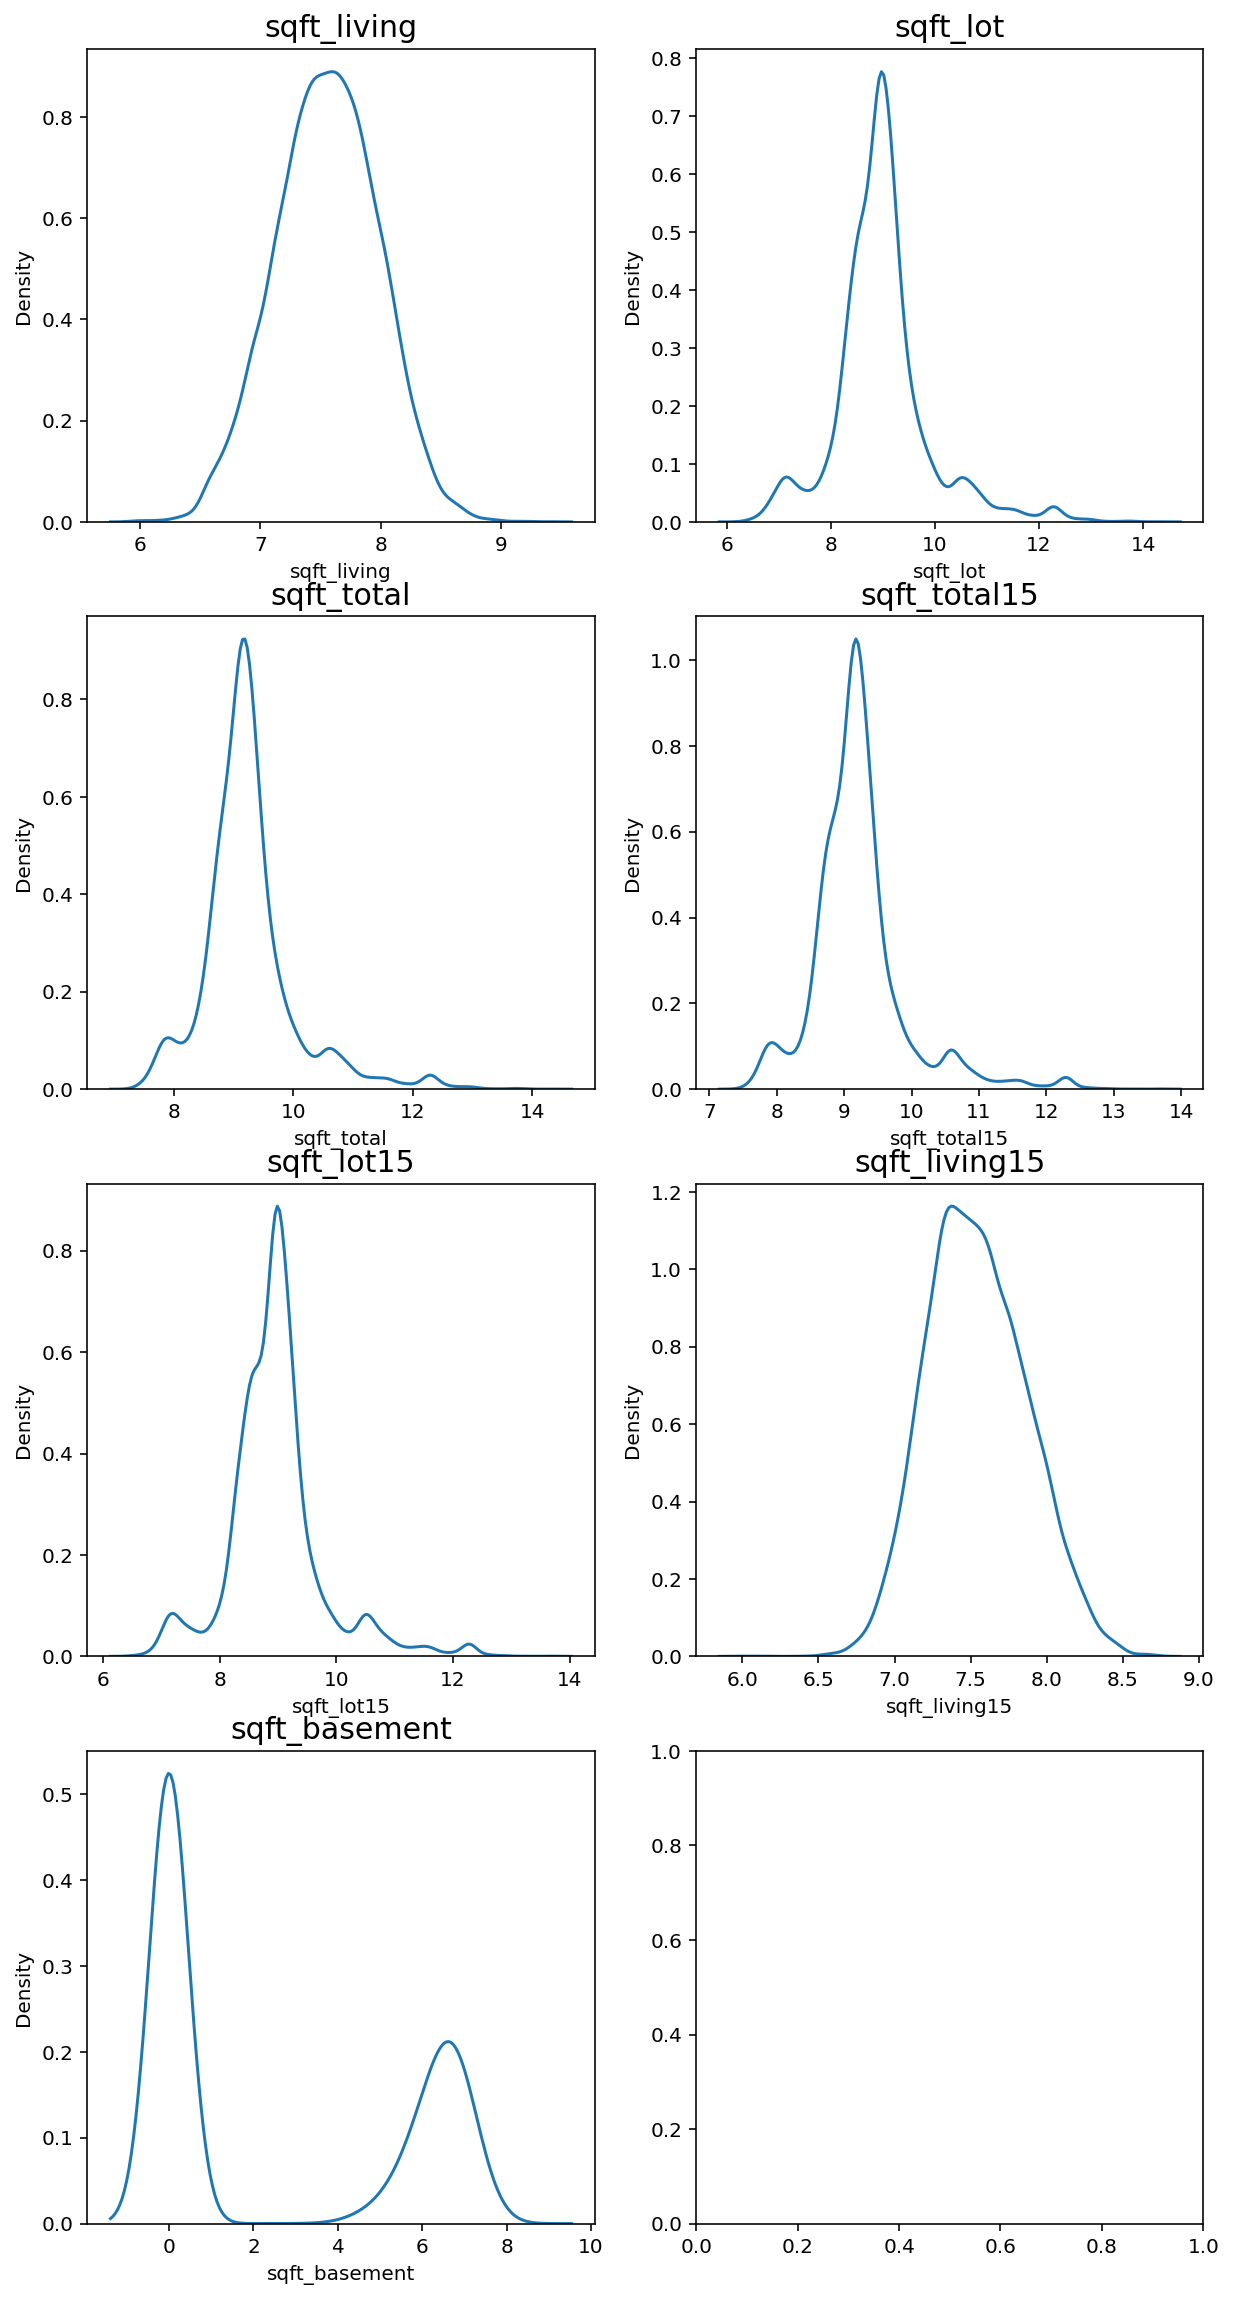

In [35]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

치우침이 많이 개선된 것을 볼 수 있다

In [36]:
X = train.drop("price", axis=1)
y = train["price"]
X_test = test

In [37]:
X.shape, y.shape, X_test.shape

((15031, 22), (15031,), (6468, 22))

위에서 봤듯이 y인 price도 치우친 분포 형태를 띄므로 log scaling 해준다.

In [39]:
y_log = np.log1p(y)

<AxesSubplot:xlabel='price', ylabel='Density'>

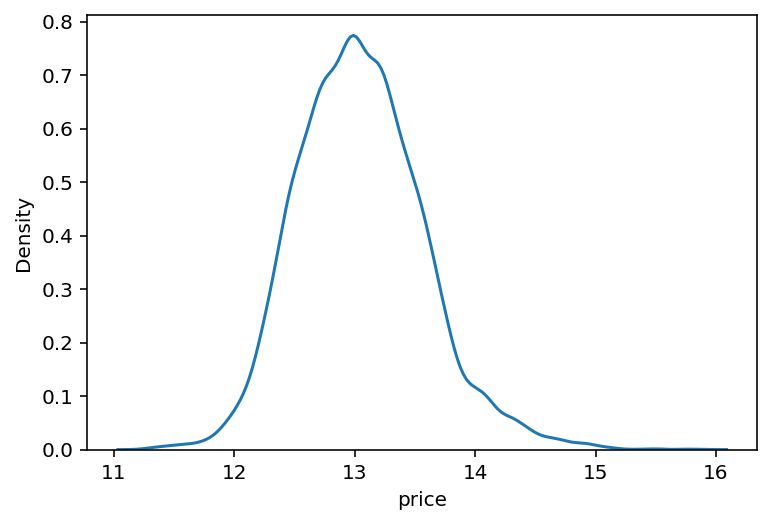

In [40]:
sns.kdeplot(y_log)

# 3. 모델링

In [41]:
xgboost = xgb.XGBRegressor(random_state=42)
lightgbm = lgb.LGBMRegressor(random_state=42)
rdforest = RandomForestRegressor(random_state=42)

models = [xgboost, lightgbm, rdforest]

In [42]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(X.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m, X=X.values, y=y_log, cv=kfold))
        print(f"Model: {m.__class__.__name__}, CV score:{CV_score:.4f}")

get_cv_score(models)

Model: XGBRegressor, CV score:0.8970
Model: LGBMRegressor, CV score:0.9024
Model: RandomForestRegressor, CV score:0.8858


In [43]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=42, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, X, y_log)

,RMSE
RandomForestRegressor,127056.803063
XGBRegressor,119374.407987
LGBMRegressor,114172.327960


# 4. 하이퍼파라미터 튜닝 및 블렌딩

## optuna
싸이킷런의 그리드탐색이나 랜덤탐색보다 쉽게 하이퍼파라미터 탐색을 할 수 있게 하는 라이브러리

In [44]:
# optuna 설치
!pip install optuna

In [54]:
import optuna

def objective(trial):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

    params = {
        'objective' : 'regression',
        'n_estimators' : trial.suggest_int('n_estimators' , 100 , 1000), 
        'learning_rate' : trial.suggest_categorical('learning_rate',[0.1, 0.01, 0.001, 0.0001]),
        'max_depth' : trial.suggest_int('max_depth' , 3 , 12),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'max_bin' : trial.suggest_int('max_bin', 100, 300),
        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        'bagging_freq' : trial.suggest_int('bagging_freq', 1, 10),
        'bagging_seed' : trial.suggest_int('bagging_seed', 1, 20),
        'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.1, 0.5),
        'feature_fraction_seed' : trial.suggest_int('feature_fraction_seed', 1, 20),
        'random_state' : 42
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    rmses = []
    final_rmse = rmse(y_valid, y_pred)
    rmses.append(final_rmse)
    
    return np.mean(rmses)
sampler = optuna.samplers.TPESampler(**optuna.samplers.TPESampler.hyperopt_parameters())
study = optuna.create_study(direction='minimize', study_name = 'lgbmregressor', sampler=sampler) 
study.optimize(objective, n_trials=100)

[I 2023-03-23 16:21:23,965] A new study created in memory with name: lgbmregressor
[I 2023-03-23 16:21:26,048] Trial 0 finished with value: 264286.1946802195 and parameters: {'n_estimators': 905, 'learning_rate': 0.001, 'max_depth': 4, 'num_leaves': 700, 'max_bin': 299, 'bagging_fraction': 0.4240140557303713, 'bagging_freq': 6, 'bagging_seed': 5, 'feature_fraction': 0.35015910244741166, 'feature_fraction_seed': 2}. Best is trial 0 with value: 264286.1946802195.


[LightGBM] [Warning] bagging_fraction is set=0.2615965163810893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2615965163810893
[LightGBM] [Warning] feature_fraction is set=0.10471027072176642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10471027072176642
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:21:27,302] Trial 1 finished with value: 164147.12644364667 and parameters: {'n_estimators': 786, 'learning_rate': 0.01, 'max_depth': 4, 'num_leaves': 930, 'max_bin': 150, 'bagging_fraction': 0.2615965163810893, 'bagging_freq': 4, 'bagging_seed': 11, 'feature_fraction': 0.10471027072176642, 'feature_fraction_seed': 17}. Best is trial 1 with value: 164147.12644364667.


[LightGBM] [Warning] bagging_fraction is set=0.6902335469326282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6902335469326282
[LightGBM] [Warning] feature_fraction is set=0.35222890960682995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35222890960682995
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:21:32,175] Trial 2 finished with value: 113867.44983428408 and parameters: {'n_estimators': 645, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 575, 'max_bin': 276, 'bagging_fraction': 0.6902335469326282, 'bagging_freq': 7, 'bagging_seed': 6, 'feature_fraction': 0.35222890960682995, 'feature_fraction_seed': 15}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.7099915862240813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7099915862240813
[LightGBM] [Warning] feature_fraction is set=0.1444953638844726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1444953638844726
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:21:32,890] Trial 3 finished with value: 338111.0454835941 and parameters: {'n_estimators': 264, 'learning_rate': 0.001, 'max_depth': 5, 'num_leaves': 17, 'max_bin': 185, 'bagging_fraction': 0.7099915862240813, 'bagging_freq': 3, 'bagging_seed': 5, 'feature_fraction': 0.1444953638844726, 'feature_fraction_seed': 5}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.38486801673024096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38486801673024096
[LightGBM] [Warning] feature_fraction is set=0.1916761311502053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1916761311502053
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:21:33,506] Trial 4 finished with value: 337507.15365690214 and parameters: {'n_estimators': 299, 'learning_rate': 0.001, 'max_depth': 4, 'num_leaves': 537, 'max_bin': 152, 'bagging_fraction': 0.38486801673024096, 'bagging_freq': 9, 'bagging_seed': 11, 'feature_fraction': 0.1916761311502053, 'feature_fraction_seed': 2}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.4315823796697783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4315823796697783
[LightGBM] [Warning] feature_fraction is set=0.2580323103525542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2580323103525542
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-23 16:21:35,081] Trial 5 finished with value: 141332.8060412348 and parameters: {'n_estimators': 817, 'learning_rate': 0.01, 'max_depth': 3, 'num_leaves': 204, 'max_bin': 184, 'bagging_fraction': 0.4315823796697783, 'bagging_freq': 1, 'bagging_seed': 11, 'feature_fraction': 0.2580323103525542, 'feature_fraction_seed': 19}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.525963384062629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525963384062629
[LightGBM] [Warning] feature_fraction is set=0.47277206427046237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47277206427046237
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:21:42,262] Trial 6 finished with value: 269516.8846788188 and parameters: {'n_estimators': 656, 'learning_rate': 0.001, 'max_depth': 9, 'num_leaves': 665, 'max_bin': 208, 'bagging_fraction': 0.525963384062629, 'bagging_freq': 10, 'bagging_seed': 14, 'feature_fraction': 0.47277206427046237, 'feature_fraction_seed': 4}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.20516513535833214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20516513535833214
[LightGBM] [Warning] feature_fraction is set=0.14651334939246113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14651334939246113
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:21:44,373] Trial 7 finished with value: 290777.9578787616 and parameters: {'n_estimators': 910, 'learning_rate': 0.001, 'max_depth': 5, 'num_leaves': 270, 'max_bin': 203, 'bagging_fraction': 0.20516513535833214, 'bagging_freq': 5, 'bagging_seed': 20, 'feature_fraction': 0.14651334939246113, 'feature_fraction_seed': 11}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.31698670745402724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31698670745402724
[LightGBM] [Warning] feature_fraction is set=0.2768681269574989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2768681269574989
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:21:45,364] Trial 8 finished with value: 353066.89111822785 and parameters: {'n_estimators': 656, 'learning_rate': 0.0001, 'max_depth': 3, 'num_leaves': 947, 'max_bin': 235, 'bagging_fraction': 0.31698670745402724, 'bagging_freq': 8, 'bagging_seed': 2, 'feature_fraction': 0.2768681269574989, 'feature_fraction_seed': 17}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.29195781160661605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29195781160661605
[LightGBM] [Warning] feature_fraction is set=0.4034783186428461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4034783186428461
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:21:48,155] Trial 9 finished with value: 347224.76871360774 and parameters: {'n_estimators': 974, 'learning_rate': 0.0001, 'max_depth': 5, 'num_leaves': 229, 'max_bin': 104, 'bagging_fraction': 0.29195781160661605, 'bagging_freq': 10, 'bagging_seed': 18, 'feature_fraction': 0.4034783186428461, 'feature_fraction_seed': 1}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.5480810517419424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5480810517419424
[LightGBM] [Warning] feature_fraction is set=0.3900516238780303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3900516238780303
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:21:51,037] Trial 10 finished with value: 115750.61628191579 and parameters: {'n_estimators': 444, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 209, 'max_bin': 204, 'bagging_fraction': 0.5480810517419424, 'bagging_freq': 3, 'bagging_seed': 15, 'feature_fraction': 0.3900516238780303, 'feature_fraction_seed': 13}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.35831313894841177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35831313894841177
[LightGBM] [Warning] feature_fraction is set=0.3285674261777357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3285674261777357
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:21:56,283] Trial 11 finished with value: 350390.1303772115 and parameters: {'n_estimators': 739, 'learning_rate': 0.0001, 'max_depth': 8, 'num_leaves': 985, 'max_bin': 295, 'bagging_fraction': 0.35831313894841177, 'bagging_freq': 3, 'bagging_seed': 14, 'feature_fraction': 0.3285674261777357, 'feature_fraction_seed': 4}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.11400259094908521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11400259094908521
[LightGBM] [Warning] feature_fraction is set=0.2213419843510478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2213419843510478
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:21:56,862] Trial 12 finished with value: 340241.94476833125 and parameters: {'n_estimators': 184, 'learning_rate': 0.001, 'max_depth': 6, 'num_leaves': 481, 'max_bin': 300, 'bagging_fraction': 0.11400259094908521, 'bagging_freq': 10, 'bagging_seed': 12, 'feature_fraction': 0.2213419843510478, 'feature_fraction_seed': 19}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.13902556979661781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13902556979661781
[LightGBM] [Warning] feature_fraction is set=0.2857444340899665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2857444340899665
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:21:57,971] Trial 13 finished with value: 171323.42611488298 and parameters: {'n_estimators': 256, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 332, 'max_bin': 206, 'bagging_fraction': 0.13902556979661781, 'bagging_freq': 4, 'bagging_seed': 15, 'feature_fraction': 0.2857444340899665, 'feature_fraction_seed': 1}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.4835344167173561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4835344167173561
[LightGBM] [Warning] feature_fraction is set=0.237705139144822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.237705139144822
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:21:58,592] Trial 14 finished with value: 122765.7729257645 and parameters: {'n_estimators': 304, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 946, 'max_bin': 249, 'bagging_fraction': 0.4835344167173561, 'bagging_freq': 4, 'bagging_seed': 1, 'feature_fraction': 0.237705139144822, 'feature_fraction_seed': 7}. Best is trial 2 with value: 113867.44983428408.


[LightGBM] [Warning] bagging_fraction is set=0.8326688596346223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8326688596346223
[LightGBM] [Warning] feature_fraction is set=0.3955095886103258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3955095886103258
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:22:01,867] Trial 15 finished with value: 113386.22774930546 and parameters: {'n_estimators': 543, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 640, 'max_bin': 100, 'bagging_fraction': 0.8326688596346223, 'bagging_freq': 6, 'bagging_seed': 17, 'feature_fraction': 0.3955095886103258, 'feature_fraction_seed': 3}. Best is trial 15 with value: 113386.22774930546.


[LightGBM] [Warning] bagging_fraction is set=0.1417080280792142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1417080280792142
[LightGBM] [Warning] feature_fraction is set=0.4378280693547292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4378280693547292
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:22:02,283] Trial 16 finished with value: 359005.72273201635 and parameters: {'n_estimators': 100, 'learning_rate': 0.0001, 'max_depth': 7, 'num_leaves': 522, 'max_bin': 148, 'bagging_fraction': 0.1417080280792142, 'bagging_freq': 9, 'bagging_seed': 4, 'feature_fraction': 0.4378280693547292, 'feature_fraction_seed': 20}. Best is trial 15 with value: 113386.22774930546.


[LightGBM] [Warning] bagging_fraction is set=0.4254966377130456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4254966377130456
[LightGBM] [Warning] feature_fraction is set=0.1775043887190563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1775043887190563
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:22:07,277] Trial 17 finished with value: 127841.90060018923 and parameters: {'n_estimators': 673, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 611, 'max_bin': 115, 'bagging_fraction': 0.4254966377130456, 'bagging_freq': 7, 'bagging_seed': 12, 'feature_fraction': 0.1775043887190563, 'feature_fraction_seed': 1}. Best is trial 15 with value: 113386.22774930546.


[LightGBM] [Warning] bagging_fraction is set=0.8043394744810448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8043394744810448
[LightGBM] [Warning] feature_fraction is set=0.19803878558012317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19803878558012317
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:22:14,246] Trial 18 finished with value: 124212.61410375035 and parameters: {'n_estimators': 927, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 302, 'max_bin': 212, 'bagging_fraction': 0.8043394744810448, 'bagging_freq': 8, 'bagging_seed': 15, 'feature_fraction': 0.19803878558012317, 'feature_fraction_seed': 20}. Best is trial 15 with value: 113386.22774930546.


[LightGBM] [Warning] bagging_fraction is set=0.8265265735265962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8265265735265962
[LightGBM] [Warning] feature_fraction is set=0.2808191605695298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2808191605695298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-23 16:22:20,311] Trial 19 finished with value: 349947.94835553836 and parameters: {'n_estimators': 825, 'learning_rate': 0.0001, 'max_depth': 8, 'num_leaves': 160, 'max_bin': 226, 'bagging_fraction': 0.8265265735265962, 'bagging_freq': 1, 'bagging_seed': 12, 'feature_fraction': 0.2808191605695298, 'feature_fraction_seed': 10}. Best is trial 15 with value: 113386.22774930546.


[LightGBM] [Warning] bagging_fraction is set=0.6904515193260139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6904515193260139
[LightGBM] [Warning] feature_fraction is set=0.49877808570495114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49877808570495114
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:22:26,181] Trial 20 finished with value: 113604.62382120926 and parameters: {'n_estimators': 542, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 787, 'max_bin': 261, 'bagging_fraction': 0.6904515193260139, 'bagging_freq': 7, 'bagging_seed': 8, 'feature_fraction': 0.49877808570495114, 'feature_fraction_seed': 13}. Best is trial 15 with value: 113386.22774930546.


[LightGBM] [Warning] bagging_fraction is set=0.89616916251148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.89616916251148
[LightGBM] [Warning] feature_fraction is set=0.4826008258379956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4826008258379956
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:22:31,746] Trial 21 finished with value: 112711.54064857445 and parameters: {'n_estimators': 477, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 821, 'max_bin': 260, 'bagging_fraction': 0.89616916251148, 'bagging_freq': 6, 'bagging_seed': 8, 'feature_fraction': 0.4826008258379956, 'feature_fraction_seed': 9}. Best is trial 21 with value: 112711.54064857445.


[LightGBM] [Warning] bagging_fraction is set=0.8898179259330933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8898179259330933
[LightGBM] [Warning] feature_fraction is set=0.4489408704023232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4489408704023232
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:22:36,338] Trial 22 finished with value: 112217.55163851567 and parameters: {'n_estimators': 413, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 819, 'max_bin': 126, 'bagging_fraction': 0.8898179259330933, 'bagging_freq': 6, 'bagging_seed': 8, 'feature_fraction': 0.4489408704023232, 'feature_fraction_seed': 8}. Best is trial 22 with value: 112217.55163851567.


[LightGBM] [Warning] bagging_fraction is set=0.8911624912333441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8911624912333441
[LightGBM] [Warning] feature_fraction is set=0.452725167191164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.452725167191164
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:22:41,307] Trial 23 finished with value: 114726.41391391128 and parameters: {'n_estimators': 420, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 825, 'max_bin': 127, 'bagging_fraction': 0.8911624912333441, 'bagging_freq': 5, 'bagging_seed': 8, 'feature_fraction': 0.452725167191164, 'feature_fraction_seed': 8}. Best is trial 22 with value: 112217.55163851567.


[LightGBM] [Warning] bagging_fraction is set=0.886348653447045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.886348653447045
[LightGBM] [Warning] feature_fraction is set=0.4996913974161553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4996913974161553
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:22:45,783] Trial 24 finished with value: 111256.99389231611 and parameters: {'n_estimators': 421, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 820, 'max_bin': 171, 'bagging_fraction': 0.886348653447045, 'bagging_freq': 6, 'bagging_seed': 9, 'feature_fraction': 0.4996913974161553, 'feature_fraction_seed': 8}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.6162164379932112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6162164379932112
[LightGBM] [Warning] feature_fraction is set=0.44576876375410013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44576876375410013
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-03-23 16:22:49,280] Trial 25 finished with value: 113939.46066975944 and parameters: {'n_estimators': 374, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 744, 'max_bin': 165, 'bagging_fraction': 0.6162164379932112, 'bagging_freq': 2, 'bagging_seed': 9, 'feature_fraction': 0.44576876375410013, 'feature_fraction_seed': 6}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.7833871956198738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7833871956198738
[LightGBM] [Warning] feature_fraction is set=0.4265895529867975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4265895529867975
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:22:52,739] Trial 26 finished with value: 115969.35157783024 and parameters: {'n_estimators': 366, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 415, 'max_bin': 126, 'bagging_fraction': 0.7833871956198738, 'bagging_freq': 5, 'bagging_seed': 3, 'feature_fraction': 0.4265895529867975, 'feature_fraction_seed': 11}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.7466299416933447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7466299416933447
[LightGBM] [Warning] feature_fraction is set=0.4987162356507967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4987162356507967
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:22:57,674] Trial 27 finished with value: 111695.3661302345 and parameters: {'n_estimators': 510, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 869, 'max_bin': 174, 'bagging_fraction': 0.7466299416933447, 'bagging_freq': 8, 'bagging_seed': 6, 'feature_fraction': 0.4987162356507967, 'feature_fraction_seed': 7}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.7435523334607684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7435523334607684
[LightGBM] [Warning] feature_fraction is set=0.48738796570829757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48738796570829757
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:23:03,456] Trial 28 finished with value: 113334.72047860904 and parameters: {'n_estimators': 583, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 873, 'max_bin': 179, 'bagging_fraction': 0.7435523334607684, 'bagging_freq': 8, 'bagging_seed': 6, 'feature_fraction': 0.48738796570829757, 'feature_fraction_seed': 13}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.6087247384095195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6087247384095195
[LightGBM] [Warning] feature_fraction is set=0.4979972919424538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4979972919424538
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:23:07,205] Trial 29 finished with value: 115437.65670808894 and parameters: {'n_estimators': 476, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 717, 'max_bin': 171, 'bagging_fraction': 0.6087247384095195, 'bagging_freq': 9, 'bagging_seed': 5, 'feature_fraction': 0.4979972919424538, 'feature_fraction_seed': 6}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.7631789853050363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7631789853050363
[LightGBM] [Warning] feature_fraction is set=0.3565040319268411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3565040319268411
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:23:08,055] Trial 30 finished with value: 113365.29903701392 and parameters: {'n_estimators': 157, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 439, 'max_bin': 142, 'bagging_fraction': 0.7631789853050363, 'bagging_freq': 7, 'bagging_seed': 10, 'feature_fraction': 0.3565040319268411, 'feature_fraction_seed': 10}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.6519850181946403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6519850181946403
[LightGBM] [Warning] feature_fraction is set=0.46180185852806166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46180185852806166
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:23:12,880] Trial 31 finished with value: 113004.08582825206 and parameters: {'n_estimators': 591, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 888, 'max_bin': 161, 'bagging_fraction': 0.6519850181946403, 'bagging_freq': 8, 'bagging_seed': 6, 'feature_fraction': 0.46180185852806166, 'feature_fraction_seed': 12}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.7372479546046049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372479546046049
[LightGBM] [Warning] feature_fraction is set=0.3236867785976486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3236867785976486
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:23:22,343] Trial 32 finished with value: 115967.87862696277 and parameters: {'n_estimators': 757, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 1012, 'max_bin': 225, 'bagging_fraction': 0.7372479546046049, 'bagging_freq': 7, 'bagging_seed': 7, 'feature_fraction': 0.3236867785976486, 'feature_fraction_seed': 16}. Best is trial 24 with value: 111256.99389231611.


[LightGBM] [Warning] bagging_fraction is set=0.8414224815048704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414224815048704
[LightGBM] [Warning] feature_fraction is set=0.4241234444911133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4241234444911133
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:23:24,952] Trial 33 finished with value: 110427.90987734962 and parameters: {'n_estimators': 515, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 47, 'max_bin': 195, 'bagging_fraction': 0.8414224815048704, 'bagging_freq': 9, 'bagging_seed': 3, 'feature_fraction': 0.4241234444911133, 'feature_fraction_seed': 6}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.850847734898364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850847734898364
[LightGBM] [Warning] feature_fraction is set=0.427697476538729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.427697476538729
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:23:26,338] Trial 34 finished with value: 316460.5476775678 and parameters: {'n_estimators': 337, 'learning_rate': 0.001, 'max_depth': 9, 'num_leaves': 23, 'max_bin': 193, 'bagging_fraction': 0.850847734898364, 'bagging_freq': 9, 'bagging_seed': 1, 'feature_fraction': 0.427697476538729, 'feature_fraction_seed': 5}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8063572295993201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063572295993201
[LightGBM] [Warning] feature_fraction is set=0.4677804584177667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4677804584177667
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:23:28,041] Trial 35 finished with value: 112257.27640475097 and parameters: {'n_estimators': 225, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 95, 'max_bin': 186, 'bagging_fraction': 0.8063572295993201, 'bagging_freq': 6, 'bagging_seed': 4, 'feature_fraction': 0.4677804584177667, 'feature_fraction_seed': 15}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.6983725433079809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6983725433079809
[LightGBM] [Warning] feature_fraction is set=0.41144020975216866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41144020975216866
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:23:32,165] Trial 36 finished with value: 278059.93033379706 and parameters: {'n_estimators': 609, 'learning_rate': 0.001, 'max_depth': 7, 'num_leaves': 353, 'max_bin': 156, 'bagging_fraction': 0.6983725433079809, 'bagging_freq': 10, 'bagging_seed': 3, 'feature_fraction': 0.41144020975216866, 'feature_fraction_seed': 3}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8527051488886879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8527051488886879
[LightGBM] [Warning] feature_fraction is set=0.3762636170730802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3762636170730802
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:23:37,555] Trial 37 finished with value: 115031.2423318533 and parameters: {'n_estimators': 716, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 105, 'max_bin': 135, 'bagging_fraction': 0.8527051488886879, 'bagging_freq': 4, 'bagging_seed': 10, 'feature_fraction': 0.3762636170730802, 'feature_fraction_seed': 9}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.7846228037874708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7846228037874708
[LightGBM] [Warning] feature_fraction is set=0.3721449499038566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3721449499038566
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-03-23 16:23:42,099] Trial 38 finished with value: 348615.27212474076 and parameters: {'n_estimators': 846, 'learning_rate': 0.0001, 'max_depth': 6, 'num_leaves': 567, 'max_bin': 224, 'bagging_fraction': 0.7846228037874708, 'bagging_freq': 2, 'bagging_seed': 2, 'feature_fraction': 0.3721449499038566, 'feature_fraction_seed': 5}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.6569545349222609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6569545349222609
[LightGBM] [Warning] feature_fraction is set=0.41047218171341626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41047218171341626
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-03-23 16:23:51,771] Trial 39 finished with value: 265781.344246134 and parameters: {'n_estimators': 695, 'learning_rate': 0.001, 'max_depth': 10, 'num_leaves': 399, 'max_bin': 193, 'bagging_fraction': 0.6569545349222609, 'bagging_freq': 2, 'bagging_seed': 19, 'feature_fraction': 0.41047218171341626, 'feature_fraction_seed': 14}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.7218033418792449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7218033418792449
[LightGBM] [Warning] feature_fraction is set=0.4759270588280311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4759270588280311
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:23:57,761] Trial 40 finished with value: 113262.08466960938 and parameters: {'n_estimators': 624, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 687, 'max_bin': 216, 'bagging_fraction': 0.7218033418792449, 'bagging_freq': 5, 'bagging_seed': 13, 'feature_fraction': 0.4759270588280311, 'feature_fraction_seed': 3}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.568478852035907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.568478852035907
[LightGBM] [Warning] feature_fraction is set=0.318664874218622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.318664874218622
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:23:59,502] Trial 41 finished with value: 355361.9370302593 and parameters: {'n_estimators': 384, 'learning_rate': 0.0001, 'max_depth': 6, 'num_leaves': 476, 'max_bin': 192, 'bagging_fraction': 0.568478852035907, 'bagging_freq': 9, 'bagging_seed': 17, 'feature_fraction': 0.318664874218622, 'feature_fraction_seed': 9}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8548305447522638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8548305447522638
[LightGBM] [Warning] feature_fraction is set=0.3431453906984615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3431453906984615
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:24:03,197] Trial 42 finished with value: 314352.7684400382 and parameters: {'n_estimators': 326, 'learning_rate': 0.001, 'max_depth': 9, 'num_leaves': 143, 'max_bin': 286, 'bagging_fraction': 0.8548305447522638, 'bagging_freq': 3, 'bagging_seed': 4, 'feature_fraction': 0.3431453906984615, 'feature_fraction_seed': 7}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.48449970883665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48449970883665
[LightGBM] [Warning] feature_fraction is set=0.4236382738506695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4236382738506695
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:24:06,503] Trial 43 finished with value: 143503.8830986573 and parameters: {'n_estimators': 260, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 235, 'max_bin': 241, 'bagging_fraction': 0.48449970883665, 'bagging_freq': 10, 'bagging_seed': 2, 'feature_fraction': 0.4236382738506695, 'feature_fraction_seed': 4}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.6676401768003608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6676401768003608
[LightGBM] [Warning] feature_fraction is set=0.38890473619475313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38890473619475313
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:24:07,386] Trial 44 finished with value: 115770.51173063999 and parameters: {'n_estimators': 480, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 55, 'max_bin': 268, 'bagging_fraction': 0.6676401768003608, 'bagging_freq': 9, 'bagging_seed': 9, 'feature_fraction': 0.38890473619475313, 'feature_fraction_seed': 12}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.7743036630789951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7743036630789951
[LightGBM] [Warning] feature_fraction is set=0.4652751742691039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4652751742691039
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:24:19,989] Trial 45 finished with value: 348106.17269104684 and parameters: {'n_estimators': 774, 'learning_rate': 0.0001, 'max_depth': 10, 'num_leaves': 597, 'max_bin': 239, 'bagging_fraction': 0.7743036630789951, 'bagging_freq': 7, 'bagging_seed': 11, 'feature_fraction': 0.4652751742691039, 'feature_fraction_seed': 2}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.7245369076206329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7245369076206329
[LightGBM] [Warning] feature_fraction is set=0.30298855872621694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30298855872621694
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:24:20,549] Trial 46 finished with value: 120795.240254613 and parameters: {'n_estimators': 203, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 274, 'max_bin': 111, 'bagging_fraction': 0.7245369076206329, 'bagging_freq': 3, 'bagging_seed': 5, 'feature_fraction': 0.30298855872621694, 'feature_fraction_seed': 18}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.39106954051310405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39106954051310405
[LightGBM] [Warning] feature_fraction is set=0.45622283351582194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45622283351582194
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:24:22,286] Trial 47 finished with value: 294625.12528064393 and parameters: {'n_estimators': 510, 'learning_rate': 0.001, 'max_depth': 5, 'num_leaves': 746, 'max_bin': 140, 'bagging_fraction': 0.39106954051310405, 'bagging_freq': 4, 'bagging_seed': 7, 'feature_fraction': 0.45622283351582194, 'feature_fraction_seed': 6}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5216432844959211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5216432844959211
[LightGBM] [Warning] feature_fraction is set=0.4393111511340248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4393111511340248
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:24:27,674] Trial 48 finished with value: 111155.46654266576 and parameters: {'n_estimators': 868, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 650, 'max_bin': 218, 'bagging_fraction': 0.5216432844959211, 'bagging_freq': 5, 'bagging_seed': 16, 'feature_fraction': 0.4393111511340248, 'feature_fraction_seed': 8}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5214306890470334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5214306890470334
[LightGBM] [Warning] feature_fraction is set=0.35743182671065193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35743182671065193
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:24:32,764] Trial 49 finished with value: 113375.83030002605 and parameters: {'n_estimators': 807, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 650, 'max_bin': 251, 'bagging_fraction': 0.5214306890470334, 'bagging_freq': 5, 'bagging_seed': 20, 'feature_fraction': 0.35743182671065193, 'feature_fraction_seed': 11}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.45359545665917755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45359545665917755
[LightGBM] [Warning] feature_fraction is set=0.43507513949037613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43507513949037613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-23 16:24:36,476] Trial 50 finished with value: 114879.59217457431 and parameters: {'n_estimators': 863, 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 546, 'max_bin': 232, 'bagging_fraction': 0.45359545665917755, 'bagging_freq': 1, 'bagging_seed': 16, 'feature_fraction': 0.43507513949037613, 'feature_fraction_seed': 4}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.26258622223910266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26258622223910266
[LightGBM] [Warning] feature_fraction is set=0.2566198183926013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2566198183926013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:24:40,249] Trial 51 finished with value: 120844.54185754852 and parameters: {'n_estimators': 993, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 470, 'max_bin': 276, 'bagging_fraction': 0.26258622223910266, 'bagging_freq': 4, 'bagging_seed': 14, 'feature_fraction': 0.2566198183926013, 'feature_fraction_seed': 14}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.32976331158263295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32976331158263295
[LightGBM] [Warning] feature_fraction is set=0.4010802078115451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010802078115451
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:24:45,485] Trial 52 finished with value: 112291.68511698961 and parameters: {'n_estimators': 930, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 365, 'max_bin': 198, 'bagging_fraction': 0.32976331158263295, 'bagging_freq': 6, 'bagging_seed': 18, 'feature_fraction': 0.4010802078115451, 'feature_fraction_seed': 16}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.3807465511657758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3807465511657758
[LightGBM] [Warning] feature_fraction is set=0.33829555141633855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33829555141633855
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-03-23 16:24:48,047] Trial 53 finished with value: 122589.69623318325 and parameters: {'n_estimators': 887, 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 166, 'max_bin': 213, 'bagging_fraction': 0.3807465511657758, 'bagging_freq': 2, 'bagging_seed': 13, 'feature_fraction': 0.33829555141633855, 'feature_fraction_seed': 2}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5544924632713601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5544924632713601
[LightGBM] [Warning] feature_fraction is set=0.3754015671120631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3754015671120631
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:24:51,503] Trial 54 finished with value: 118977.11255802654 and parameters: {'n_estimators': 660, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 617, 'max_bin': 249, 'bagging_fraction': 0.5544924632713601, 'bagging_freq': 10, 'bagging_seed': 16, 'feature_fraction': 0.3754015671120631, 'feature_fraction_seed': 5}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.44985830512252456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44985830512252456
[LightGBM] [Warning] feature_fraction is set=0.44233803282788464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44233803282788464
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:24:53,049] Trial 55 finished with value: 350209.54743055196 and parameters: {'n_estimators': 959, 'learning_rate': 0.0001, 'max_depth': 5, 'num_leaves': 5, 'max_bin': 294, 'bagging_fraction': 0.44985830512252456, 'bagging_freq': 7, 'bagging_seed': 13, 'feature_fraction': 0.44233803282788464, 'feature_fraction_seed': 10}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.21444439545577054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21444439545577054
[LightGBM] [Warning] feature_fraction is set=0.10261923043810978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10261923043810978
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:24:53,562] Trial 56 finished with value: 303328.0818698952 and parameters: {'n_estimators': 105, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 318, 'max_bin': 184, 'bagging_fraction': 0.21444439545577054, 'bagging_freq': 5, 'bagging_seed': 19, 'feature_fraction': 0.10261923043810978, 'feature_fraction_seed': 8}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.4991811402164689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4991811402164689
[LightGBM] [Warning] feature_fraction is set=0.4810198291610389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4810198291610389
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:24:55,301] Trial 57 finished with value: 123989.07506855633 and parameters: {'n_estimators': 731, 'learning_rate': 0.01, 'max_depth': 4, 'num_leaves': 509, 'max_bin': 217, 'bagging_fraction': 0.4991811402164689, 'bagging_freq': 8, 'bagging_seed': 16, 'feature_fraction': 0.4810198291610389, 'feature_fraction_seed': 12}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5862174059568589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5862174059568589
[LightGBM] [Warning] feature_fraction is set=0.4134259163460335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134259163460335
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:25:00,366] Trial 58 finished with value: 351983.15296150726 and parameters: {'n_estimators': 560, 'learning_rate': 0.0001, 'max_depth': 8, 'num_leaves': 910, 'max_bin': 204, 'bagging_fraction': 0.5862174059568589, 'bagging_freq': 3, 'bagging_seed': 19, 'feature_fraction': 0.4134259163460335, 'feature_fraction_seed': 6}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5162218128173599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162218128173599
[LightGBM] [Warning] feature_fraction is set=0.3023349354161009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3023349354161009
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:25:07,479] Trial 59 finished with value: 273527.7804803204 and parameters: {'n_estimators': 699, 'learning_rate': 0.001, 'max_depth': 9, 'num_leaves': 961, 'max_bin': 278, 'bagging_fraction': 0.5162218128173599, 'bagging_freq': 8, 'bagging_seed': 12, 'feature_fraction': 0.3023349354161009, 'feature_fraction_seed': 7}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5349204621400405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5349204621400405
[LightGBM] [Warning] feature_fraction is set=0.11955334267616366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11955334267616366
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:25:09,755] Trial 60 finished with value: 147759.78028521515 and parameters: {'n_estimators': 630, 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 769, 'max_bin': 258, 'bagging_fraction': 0.5349204621400405, 'bagging_freq': 4, 'bagging_seed': 17, 'feature_fraction': 0.11955334267616366, 'feature_fraction_seed': 18}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.6298668255794722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6298668255794722
[LightGBM] [Warning] feature_fraction is set=0.3869250288981922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3869250288981922
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:25:12,658] Trial 61 finished with value: 355969.27157377324 and parameters: {'n_estimators': 298, 'learning_rate': 0.0001, 'max_depth': 8, 'num_leaves': 247, 'max_bin': 231, 'bagging_fraction': 0.6298668255794722, 'bagging_freq': 5, 'bagging_seed': 15, 'feature_fraction': 0.3869250288981922, 'feature_fraction_seed': 1}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.6866046820034912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6866046820034912
[LightGBM] [Warning] feature_fraction is set=0.45126338182374703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45126338182374703
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:25:18,284] Trial 62 finished with value: 254039.73090605243 and parameters: {'n_estimators': 813, 'learning_rate': 0.001, 'max_depth': 7, 'num_leaves': 193, 'max_bin': 152, 'bagging_fraction': 0.6866046820034912, 'bagging_freq': 7, 'bagging_seed': 11, 'feature_fraction': 0.45126338182374703, 'feature_fraction_seed': 9}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5915272879741309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5915272879741309
[LightGBM] [Warning] feature_fraction is set=0.36260151587771167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36260151587771167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-03-23 16:25:20,066] Trial 63 finished with value: 129218.13684129425 and parameters: {'n_estimators': 438, 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 695, 'max_bin': 165, 'bagging_fraction': 0.5915272879741309, 'bagging_freq': 1, 'bagging_seed': 7, 'feature_fraction': 0.36260151587771167, 'feature_fraction_seed': 3}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.5578513199581483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5578513199581483
[LightGBM] [Warning] feature_fraction is set=0.39803249337563007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39803249337563007
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:25:25,807] Trial 64 finished with value: 117121.91849855045 and parameters: {'n_estimators': 785, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 406, 'max_bin': 243, 'bagging_fraction': 0.5578513199581483, 'bagging_freq': 6, 'bagging_seed': 20, 'feature_fraction': 0.39803249337563007, 'feature_fraction_seed': 14}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8995342630821673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995342630821673
[LightGBM] [Warning] feature_fraction is set=0.4693081192336024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4693081192336024
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:25:30,941] Trial 65 finished with value: 113491.96103480882 and parameters: {'n_estimators': 516, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 841, 'max_bin': 200, 'bagging_fraction': 0.8995342630821673, 'bagging_freq': 6, 'bagging_seed': 9, 'feature_fraction': 0.4693081192336024, 'feature_fraction_seed': 8}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8669327280266137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8669327280266137
[LightGBM] [Warning] feature_fraction is set=0.4895279717331005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4895279717331005
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:25:35,690] Trial 66 finished with value: 113485.59750168622 and parameters: {'n_estimators': 405, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 795, 'max_bin': 177, 'bagging_fraction': 0.8669327280266137, 'bagging_freq': 8, 'bagging_seed': 1, 'feature_fraction': 0.4895279717331005, 'feature_fraction_seed': 10}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8280202052438235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280202052438235
[LightGBM] [Warning] feature_fraction is set=0.4401971261063473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4401971261063473
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:25:39,890] Trial 67 finished with value: 111978.21606451756 and parameters: {'n_estimators': 460, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 1023, 'max_bin': 168, 'bagging_fraction': 0.8280202052438235, 'bagging_freq': 9, 'bagging_seed': 10, 'feature_fraction': 0.4401971261063473, 'feature_fraction_seed': 7}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.7572659732748444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7572659732748444
[LightGBM] [Warning] feature_fraction is set=0.475848697480765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.475848697480765
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:25:45,185] Trial 68 finished with value: 113303.98852817022 and parameters: {'n_estimators': 547, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 658, 'max_bin': 185, 'bagging_fraction': 0.7572659732748444, 'bagging_freq': 6, 'bagging_seed': 3, 'feature_fraction': 0.475848697480765, 'feature_fraction_seed': 8}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8077679856551907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8077679856551907
[LightGBM] [Warning] feature_fraction is set=0.4603715462059257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4603715462059257
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:25:47,886] Trial 69 finished with value: 111490.13901103419 and parameters: {'n_estimators': 361, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 728, 'max_bin': 208, 'bagging_fraction': 0.8077679856551907, 'bagging_freq': 5, 'bagging_seed': 5, 'feature_fraction': 0.4603715462059257, 'feature_fraction_seed': 5}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8798487621458448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8798487621458448
[LightGBM] [Warning] feature_fraction is set=0.4256511408502343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4256511408502343
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:25:54,162] Trial 70 finished with value: 115280.88873626085 and parameters: {'n_estimators': 574, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 579, 'max_bin': 144, 'bagging_fraction': 0.8798487621458448, 'bagging_freq': 3, 'bagging_seed': 14, 'feature_fraction': 0.4256511408502343, 'feature_fraction_seed': 4}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.7047649291567675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7047649291567675
[LightGBM] [Warning] feature_fraction is set=0.48718796356049804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48718796356049804
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:25:56,661] Trial 71 finished with value: 114095.57516566115 and parameters: {'n_estimators': 280, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 929, 'max_bin': 160, 'bagging_fraction': 0.7047649291567675, 'bagging_freq': 7, 'bagging_seed': 9, 'feature_fraction': 0.48718796356049804, 'feature_fraction_seed': 11}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.7926781196379871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7926781196379871
[LightGBM] [Warning] feature_fraction is set=0.451878539249025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.451878539249025
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:26:00,489] Trial 72 finished with value: 114017.4976439053 and parameters: {'n_estimators': 526, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 849, 'max_bin': 223, 'bagging_fraction': 0.7926781196379871, 'bagging_freq': 4, 'bagging_seed': 7, 'feature_fraction': 0.451878539249025, 'feature_fraction_seed': 9}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.8422275162785854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8422275162785854
[LightGBM] [Warning] feature_fraction is set=0.4174530294863591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4174530294863591
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:26:04,975] Trial 73 finished with value: 323946.1038590004 and parameters: {'n_estimators': 240, 'learning_rate': 0.001, 'max_depth': 11, 'num_leaves': 766, 'max_bin': 131, 'bagging_fraction': 0.8422275162785854, 'bagging_freq': 10, 'bagging_seed': 2, 'feature_fraction': 0.4174530294863591, 'feature_fraction_seed': 6}. Best is trial 33 with value: 110427.90987734962.


[LightGBM] [Warning] bagging_fraction is set=0.814671870321511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814671870321511
[LightGBM] [Warning] feature_fraction is set=0.43177252671869065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43177252671869065
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:26:07,804] Trial 74 finished with value: 110294.14154456441 and parameters: {'n_estimators': 493, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 986, 'max_bin': 119, 'bagging_fraction': 0.814671870321511, 'bagging_freq': 9, 'bagging_seed': 8, 'feature_fraction': 0.43177252671869065, 'feature_fraction_seed': 12}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8169152919341625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8169152919341625
[LightGBM] [Warning] feature_fraction is set=0.40439081839115265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40439081839115265
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:26:14,366] Trial 75 finished with value: 349860.88808126515 and parameters: {'n_estimators': 691, 'learning_rate': 0.0001, 'max_depth': 8, 'num_leaves': 280, 'max_bin': 113, 'bagging_fraction': 0.8169152919341625, 'bagging_freq': 9, 'bagging_seed': 6, 'feature_fraction': 0.40439081839115265, 'feature_fraction_seed': 13}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7598463419327216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7598463419327216
[LightGBM] [Warning] feature_fraction is set=0.38571091389372897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38571091389372897
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:26:17,774] Trial 76 finished with value: 112823.68964660334 and parameters: {'n_estimators': 752, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 435, 'max_bin': 106, 'bagging_fraction': 0.7598463419327216, 'bagging_freq': 10, 'bagging_seed': 4, 'feature_fraction': 0.38571091389372897, 'feature_fraction_seed': 12}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.737299003980481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.737299003980481
[LightGBM] [Warning] feature_fraction is set=0.43135889630238694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43135889630238694
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:26:22,154] Trial 77 finished with value: 117511.60543306242 and parameters: {'n_estimators': 602, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 979, 'max_bin': 123, 'bagging_fraction': 0.737299003980481, 'bagging_freq': 9, 'bagging_seed': 8, 'feature_fraction': 0.43135889630238694, 'feature_fraction_seed': 15}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8022884069880596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8022884069880596
[LightGBM] [Warning] feature_fraction is set=0.4435147422706813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4435147422706813
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:26:24,648] Trial 78 finished with value: 114263.64454554491 and parameters: {'n_estimators': 492, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 369, 'max_bin': 267, 'bagging_fraction': 0.8022884069880596, 'bagging_freq': 8, 'bagging_seed': 12, 'feature_fraction': 0.4435147422706813, 'feature_fraction_seed': 11}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.6308538097025036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6308538097025036
[LightGBM] [Warning] feature_fraction is set=0.367494148106471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.367494148106471
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:26:28,751] Trial 79 finished with value: 117200.24291818093 and parameters: {'n_estimators': 639, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 77, 'max_bin': 149, 'bagging_fraction': 0.6308538097025036, 'bagging_freq': 10, 'bagging_seed': 3, 'feature_fraction': 0.367494148106471, 'feature_fraction_seed': 10}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.6765472539763002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6765472539763002
[LightGBM] [Warning] feature_fraction is set=0.34405842031400163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34405842031400163
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:26:31,689] Trial 80 finished with value: 313359.70300676895 and parameters: {'n_estimators': 335, 'learning_rate': 0.001, 'max_depth': 8, 'num_leaves': 908, 'max_bin': 116, 'bagging_fraction': 0.6765472539763002, 'bagging_freq': 9, 'bagging_seed': 5, 'feature_fraction': 0.34405842031400163, 'feature_fraction_seed': 16}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7236494860524729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7236494860524729
[LightGBM] [Warning] feature_fraction is set=0.39480493856878873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39480493856878873
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:26:32,642] Trial 81 finished with value: 116987.63786280522 and parameters: {'n_estimators': 451, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 508, 'max_bin': 100, 'bagging_fraction': 0.7236494860524729, 'bagging_freq': 7, 'bagging_seed': 11, 'feature_fraction': 0.39480493856878873, 'feature_fraction_seed': 17}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7774353168829464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7774353168829464
[LightGBM] [Warning] feature_fraction is set=0.4157923391963259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4157923391963259
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:26:36,090] Trial 82 finished with value: 350761.40019218327 and parameters: {'n_estimators': 667, 'learning_rate': 0.0001, 'max_depth': 6, 'num_leaves': 131, 'max_bin': 121, 'bagging_fraction': 0.7774353168829464, 'bagging_freq': 8, 'bagging_seed': 18, 'feature_fraction': 0.4157923391963259, 'feature_fraction_seed': 14}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8711726682641979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8711726682641979
[LightGBM] [Warning] feature_fraction is set=0.35539334579832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35539334579832
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:26:42,085] Trial 83 finished with value: 124003.53099425246 and parameters: {'n_estimators': 401, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 634, 'max_bin': 218, 'bagging_fraction': 0.8711726682641979, 'bagging_freq': 7, 'bagging_seed': 10, 'feature_fraction': 0.35539334579832, 'feature_fraction_seed': 13}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7109557641147862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7109557641147862
[LightGBM] [Warning] feature_fraction is set=0.3767776750423141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3767776750423141
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:26:47,977] Trial 84 finished with value: 117498.72497784552 and parameters: {'n_estimators': 864, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 546, 'max_bin': 135, 'bagging_fraction': 0.7109557641147862, 'bagging_freq': 10, 'bagging_seed': 1, 'feature_fraction': 0.3767776750423141, 'feature_fraction_seed': 3}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8337065300569738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8337065300569738
[LightGBM] [Warning] feature_fraction is set=0.405535402984531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.405535402984531
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:26:48,840] Trial 85 finished with value: 115143.86492873043 and parameters: {'n_estimators': 142, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 677, 'max_bin': 197, 'bagging_fraction': 0.8337065300569738, 'bagging_freq': 8, 'bagging_seed': 15, 'feature_fraction': 0.405535402984531, 'feature_fraction_seed': 19}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.6929844246480514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6929844246480514
[LightGBM] [Warning] feature_fraction is set=0.43564965205686623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43564965205686623
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:26:53,867] Trial 86 finished with value: 112493.35010685636 and parameters: {'n_estimators': 943, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 43, 'max_bin': 189, 'bagging_fraction': 0.6929844246480514, 'bagging_freq': 6, 'bagging_seed': 13, 'feature_fraction': 0.43564965205686623, 'feature_fraction_seed': 15}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.6536589668662071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6536589668662071
[LightGBM] [Warning] feature_fraction is set=0.46096255078205456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46096255078205456
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:26:57,203] Trial 87 finished with value: 253709.1028539063 and parameters: {'n_estimators': 896, 'learning_rate': 0.001, 'max_depth': 5, 'num_leaves': 995, 'max_bin': 179, 'bagging_fraction': 0.6536589668662071, 'bagging_freq': 5, 'bagging_seed': 6, 'feature_fraction': 0.46096255078205456, 'feature_fraction_seed': 7}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7551458839061345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7551458839061345
[LightGBM] [Warning] feature_fraction is set=0.3128852445223713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3128852445223713
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-03-23 16:27:04,396] Trial 88 finished with value: 352334.9986806071 and parameters: {'n_estimators': 575, 'learning_rate': 0.0001, 'max_depth': 9, 'num_leaves': 446, 'max_bin': 283, 'bagging_fraction': 0.7551458839061345, 'bagging_freq': 4, 'bagging_seed': 2, 'feature_fraction': 0.3128852445223713, 'feature_fraction_seed': 12}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8198431813265099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198431813265099
[LightGBM] [Warning] feature_fraction is set=0.3311044617121923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3311044617121923
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:27:07,786] Trial 89 finished with value: 113471.81036073522 and parameters: {'n_estimators': 618, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 188, 'max_bin': 254, 'bagging_fraction': 0.8198431813265099, 'bagging_freq': 9, 'bagging_seed': 17, 'feature_fraction': 0.3311044617121923, 'feature_fraction_seed': 20}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7914015685967216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914015685967216
[LightGBM] [Warning] feature_fraction is set=0.28711076799024365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28711076799024365
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-03-23 16:27:10,375] Trial 90 finished with value: 130851.0505770497 and parameters: {'n_estimators': 996, 'learning_rate': 0.01, 'max_depth': 4, 'num_leaves': 714, 'max_bin': 157, 'bagging_fraction': 0.7914015685967216, 'bagging_freq': 2, 'bagging_seed': 4, 'feature_fraction': 0.28711076799024365, 'feature_fraction_seed': 10}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.6740551160122964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6740551160122964
[LightGBM] [Warning] feature_fraction is set=0.42517392801153264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42517392801153264
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:27:13,486] Trial 91 finished with value: 113251.74659291272 and parameters: {'n_estimators': 840, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 300, 'max_bin': 246, 'bagging_fraction': 0.6740551160122964, 'bagging_freq': 9, 'bagging_seed': 8, 'feature_fraction': 0.42517392801153264, 'feature_fraction_seed': 5}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8607167717298645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8607167717298645
[LightGBM] [Warning] feature_fraction is set=0.3822785455196376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3822785455196376
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-03-23 16:27:19,067] Trial 92 finished with value: 115942.85963883174 and parameters: {'n_estimators': 722, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 384, 'max_bin': 267, 'bagging_fraction': 0.8607167717298645, 'bagging_freq': 10, 'bagging_seed': 3, 'feature_fraction': 0.3822785455196376, 'feature_fraction_seed': 9}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8789573577102108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8789573577102108
[LightGBM] [Warning] feature_fraction is set=0.46849752496456665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46849752496456665
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-03-23 16:27:22,982] Trial 93 finished with value: 291588.4944515491 and parameters: {'n_estimators': 486, 'learning_rate': 0.001, 'max_depth': 7, 'num_leaves': 805, 'max_bin': 237, 'bagging_fraction': 0.8789573577102108, 'bagging_freq': 8, 'bagging_seed': 7, 'feature_fraction': 0.46849752496456665, 'feature_fraction_seed': 2}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.8499365166545949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8499365166545949
[LightGBM] [Warning] feature_fraction is set=0.35061744335400646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35061744335400646
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:27:30,701] Trial 94 finished with value: 353755.2378243804 and parameters: {'n_estimators': 434, 'learning_rate': 0.0001, 'max_depth': 11, 'num_leaves': 336, 'max_bin': 209, 'bagging_fraction': 0.8499365166545949, 'bagging_freq': 7, 'bagging_seed': 10, 'feature_fraction': 0.35061744335400646, 'feature_fraction_seed': 6}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7704151896042959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7704151896042959
[LightGBM] [Warning] feature_fraction is set=0.44922441910741095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44922441910741095
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-03-23 16:27:35,538] Trial 95 finished with value: 116236.36372068818 and parameters: {'n_estimators': 649, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 885, 'max_bin': 139, 'bagging_fraction': 0.7704151896042959, 'bagging_freq': 5, 'bagging_seed': 12, 'feature_fraction': 0.44922441910741095, 'feature_fraction_seed': 17}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.5758904134756552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5758904134756552
[LightGBM] [Warning] feature_fraction is set=0.3948102258692277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948102258692277
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-03-23 16:27:39,500] Trial 96 finished with value: 124264.4901739089 and parameters: {'n_estimators': 354, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 219, 'max_bin': 229, 'bagging_fraction': 0.5758904134756552, 'bagging_freq': 3, 'bagging_seed': 16, 'feature_fraction': 0.3948102258692277, 'feature_fraction_seed': 8}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.5408221801622541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5408221801622541
[LightGBM] [Warning] feature_fraction is set=0.41944342159563763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41944342159563763
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-03-23 16:27:42,277] Trial 97 finished with value: 112649.9757627812 and parameters: {'n_estimators': 305, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 495, 'max_bin': 173, 'bagging_fraction': 0.5408221801622541, 'bagging_freq': 7, 'bagging_seed': 9, 'feature_fraction': 0.41944342159563763, 'feature_fraction_seed': 4}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.6022515581236867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6022515581236867
[LightGBM] [Warning] feature_fraction is set=0.47824629408168573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47824629408168573
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-03-23 16:27:45,100] Trial 98 finished with value: 284055.6622268759 and parameters: {'n_estimators': 560, 'learning_rate': 0.001, 'max_depth': 6, 'num_leaves': 952, 'max_bin': 106, 'bagging_fraction': 0.6022515581236867, 'bagging_freq': 6, 'bagging_seed': 13, 'feature_fraction': 0.47824629408168573, 'feature_fraction_seed': 11}. Best is trial 74 with value: 110294.14154456441.


[LightGBM] [Warning] bagging_fraction is set=0.7399116841863435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399116841863435
[LightGBM] [Warning] feature_fraction is set=0.3638726987978138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3638726987978138
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-03-23 16:27:46,560] Trial 99 finished with value: 170606.30530439643 and parameters: {'n_estimators': 205, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 579, 'max_bin': 221, 'bagging_fraction': 0.7399116841863435, 'bagging_freq': 9, 'bagging_seed': 2, 'feature_fraction': 0.3638726987978138, 'feature_fraction_seed': 9}. Best is trial 74 with value: 110294.14154456441.


In [46]:
def objective(trial):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

    xgb_params = {
        'max_depth' : trial.suggest_int('max_depth' , 3 , 12),
        'learning_rate' : trial.suggest_categorical('learning_rate',[0.1, 0.01, 0.001, 0.0001]),
        'n_estimators' : trial.suggest_int('n_estimators' , 100 , 1000), 
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1]),
        'seed' : 42
        }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    rmses = []
    final_rmse = rmse(y_valid, y_pred)
    rmses.append(final_rmse)
    
    return np.mean(rmses)
sampler = optuna.samplers.TPESampler(**optuna.samplers.TPESampler.hyperopt_parameters())
study1 = optuna.create_study(direction='minimize', study_name = 'xgbregressor', sampler=sampler) 
study1.optimize(objective, n_trials=100)

[I 2023-03-23 15:51:36,896] A new study created in memory with name: xgbregressor
[I 2023-03-23 15:52:08,102] Trial 0 finished with value: 111250.43940888326 and parameters: {'max_depth': 8, 'learning_rate': 0.1, 'n_estimators': 837, 'colsample_bytree': 0.8, 'subsample': 0.7}. Best is trial 0 with value: 111250.43940888326.
[I 2023-03-23 15:52:17,581] Trial 1 finished with value: 646232.4100332846 and parameters: {'max_depth': 7, 'learning_rate': 0.0001, 'n_estimators': 786, 'colsample_bytree': 0.8, 'subsample': 0.7}. Best is trial 0 with value: 111250.43940888326.
[I 2023-03-23 15:52:28,626] Trial 2 finished with value: 646231.9278135991 and parameters: {'max_depth': 8, 'learning_rate': 0.0001, 'n_estimators': 893, 'colsample_bytree': 0.8, 'subsample': 0.9}. Best is trial 0 with value: 111250.43940888326.
[I 2023-03-23 15:52:30,199] Trial 3 finished with value: 640438.3936839678 and parameters: {'max_depth': 8, 'learning_rate': 0.01, 'n_estimators': 105, 'colsample_bytree': 0.8, 'subs

[I 2023-03-23 16:00:55,670] Trial 32 finished with value: 646233.1416395976 and parameters: {'max_depth': 4, 'learning_rate': 0.0001, 'n_estimators': 595, 'colsample_bytree': 0.9, 'subsample': 0.6}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23 16:01:13,019] Trial 33 finished with value: 118958.9351264153 and parameters: {'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 743, 'colsample_bytree': 0.8, 'subsample': 0.6}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23 16:01:22,260] Trial 34 finished with value: 113123.36883317723 and parameters: {'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 393, 'colsample_bytree': 0.7, 'subsample': 0.6}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23 16:01:28,876] Trial 35 finished with value: 646233.421203116 and parameters: {'max_depth': 5, 'learning_rate': 0.0001, 'n_estimators': 510, 'colsample_bytree': 0.9, 'subsample': 0.6}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23

[I 2023-03-23 16:07:35,450] Trial 64 finished with value: 111240.62236995371 and parameters: {'max_depth': 9, 'learning_rate': 0.1, 'n_estimators': 341, 'colsample_bytree': 0.8, 'subsample': 0.9}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23 16:07:50,634] Trial 65 finished with value: 109898.97077302648 and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 489, 'colsample_bytree': 0.8, 'subsample': 0.9}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23 16:08:02,202] Trial 66 finished with value: 109867.39965196367 and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 376, 'colsample_bytree': 0.8, 'subsample': 0.9}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23 16:08:10,336] Trial 67 finished with value: 111175.60259801589 and parameters: {'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 314, 'colsample_bytree': 0.8, 'subsample': 0.9}. Best is trial 31 with value: 107837.57900179992.
[I 2023-03-23 16

[I 2023-03-23 16:16:26,146] Trial 96 finished with value: 109244.08612007696 and parameters: {'max_depth': 11, 'learning_rate': 0.01, 'n_estimators': 963, 'colsample_bytree': 0.6, 'subsample': 0.8}. Best is trial 91 with value: 106995.26565701545.
[I 2023-03-23 16:16:47,253] Trial 97 finished with value: 111799.20638261377 and parameters: {'max_depth': 11, 'learning_rate': 0.1, 'n_estimators': 372, 'colsample_bytree': 0.8, 'subsample': 0.6}. Best is trial 91 with value: 106995.26565701545.
[I 2023-03-23 16:17:02,493] Trial 98 finished with value: 108686.48988087874 and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 447, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 91 with value: 106995.26565701545.
[I 2023-03-23 16:17:15,620] Trial 99 finished with value: 109723.9334100097 and parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 614, 'colsample_bytree': 0.8, 'subsample': 0.6}. Best is trial 91 with value: 106995.26565701545.


In [55]:
best_params = study.best_trial.params

lightgbm = lgb.LGBMRegressor(n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"],
                            learning_rate=best_params["learning_rate"], num_leaves=best_params["num_leaves"], 
                             max_bin=best_params["max_bin"], bagging_fraction=best_params["bagging_fraction"],
                             bagging_freq=best_params["bagging_freq"], bagging_seed=best_params["bagging_seed"],
                             feature_fraction=best_params["feature_fraction"], feature_fraction_seed=best_params["feature_fraction_seed"],
                             random_state=42)

lightgbm.fit(X, y_log)
y_pred_lgbm = np.expm1(lightgbm.predict(X_test))

[LightGBM] [Warning] bagging_fraction is set=0.814671870321511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814671870321511
[LightGBM] [Warning] feature_fraction is set=0.43177252671869065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43177252671869065
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


In [56]:
best_params_xgb = study1.best_trial.params

xgbr = xgb.XGBRegressor(n_estimators=best_params_xgb["n_estimators"], max_depth=best_params_xgb["max_depth"],
                        learning_rate=best_params_xgb["learning_rate"], subsample=best_params_xgb["subsample"], 
                        colsample_bytree=best_params_xgb["colsample_bytree"], seed=42)

xgbr.fit(X, y_log)
y_pred_xgb = np.expm1(xgbr.predict(X_test))

In [68]:
y_pred = 0.2 * y_pred_lgbm + 0.8 * y_pred_xgb

# 5. 제출

In [69]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['price'] = y_pred

submission_csv_path = f'./submission_ensemble_add_feature.csv'
submission.to_csv(submission_csv_path, index=False)

# 6. 결과

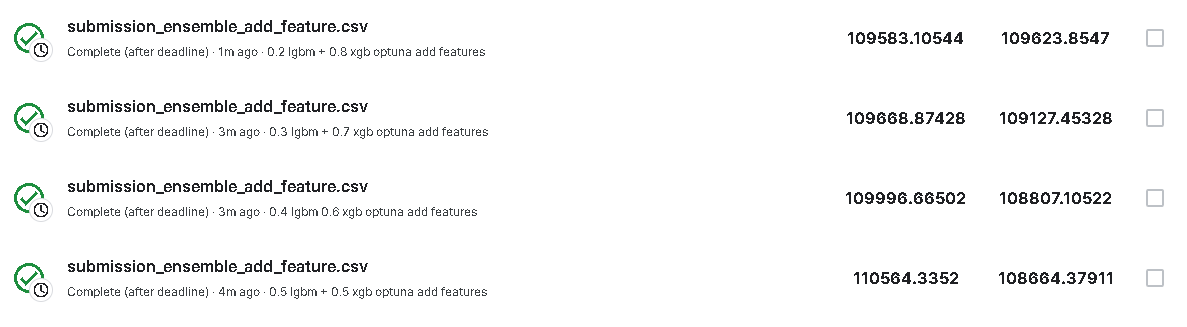
모델 별 반영 비율을 바꿔서 실행해 본 결과 lgbm 0.2 + xgb 0.8로 했을 때가 성능이 제일 좋게 나왔다. <br>
아래가 성능이 제일 높았던 비율 조합이다.

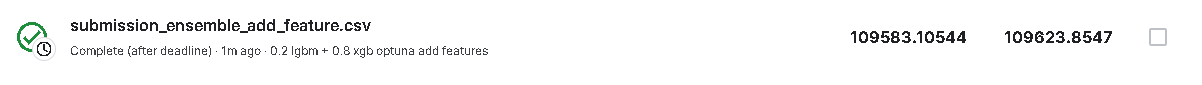

# 7. 회고

- feature engineering의 중요성을 느낄 수 있었다. 상관계수가 높은 feature들로 새로운 feature를 생성하니까 성능이 더 좋아졌다.
- postcode와 위도, 경도 정보로 추가 feature를 생성하는 것도 나쁘지 않을 것 같다. 클러스터링으로 비슷한 군집끼리 묶어서 추가적인 feature를 생성하는 작업을 할 수 있을 것 같다.
- 상관관계가 낮은 feature를 제거했을 때 오히려 성능이 나빠졌다. feature selection도 신중히 해야한다는 것을 느꼈다.
- EDA의 중요성을 다시 한 번 깨달았다. EDA를 통해 feature의 특성을 파악할 수 있었고, 이상치도 찾아서 제거할 수 있었다.
- 설명변수 간 관계를 파악하는 등 다양한 관점에서 데이터를 살펴보면 성능을 더 끌어올릴 수 있을 것 같다.
- 모델 간 반영 비율을 다르게 하여 성능을 끌어올릴 수 있음을 깨달았다.
- 다른 모델을 더 실험하여 성능을 끌어올려볼 수 있을 것 같다.
- grid search나 random search 대신 optuna를 사용하여 좀 더 편하게 하이퍼파라미터 튜닝을 진행했다. pycaret이라는 라이브러리를 사용하면 모델 선택, 블렌딩 등을 더 쉽게 할 수 있는데 한 번 써보는 것도 좋을 것 같다고 느꼈다.